<h1> Importing Libraries</h1>

In [19]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings

In [6]:
warnings.simplefilter('ignore')

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [9]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image

In [12]:
# !pip install mlxtend

In [14]:
from mlxtend.frequent_patterns import apriori, association_rules

<h1> Reading Cleaned Data </h1>

In [21]:
df = pd.read_pickle('cleaned.pkl')

In [22]:
df.shape

(7549676, 44)

In [23]:
df.columns

Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)', 'Description', 'Street', 'City', 'State', 'Zipcode',
       'Airport_Code', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Day', 'month', 'Hour_of_Day',
       'Year', 'Day_of_Week', 'Is_Weekend', 'Temperature_Category',
       'Distance_Category', 'Humidity_Category', 'Pressure_Category',
       'Wind_Speed_Category', 'Precipitation_Category', 'Visibility_Category'],
      dtype='object')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7549676 entries, 0 to 7549711
Data columns (total 44 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Severity                int64         
 1   Start_Time              datetime64[ns]
 2   End_Time                datetime64[ns]
 3   Start_Lat               float64       
 4   Start_Lng               float64       
 5   Distance(mi)            float64       
 6   Description             object        
 7   Street                  object        
 8   City                    object        
 9   State                   object        
 10  Zipcode                 int64         
 11  Airport_Code            object        
 12  Temperature(F)          float64       
 13  Humidity(%)             float64       
 14  Pressure(in)            float64       
 15  Visibility(mi)          float64       
 16  Wind_Speed(mph)         float64       
 17  Precipitation(in)       float64       
 18  Weather

<h1> Exploratory Data Analysis </h1>

<b> Looking for Trends in Numeric Columns

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


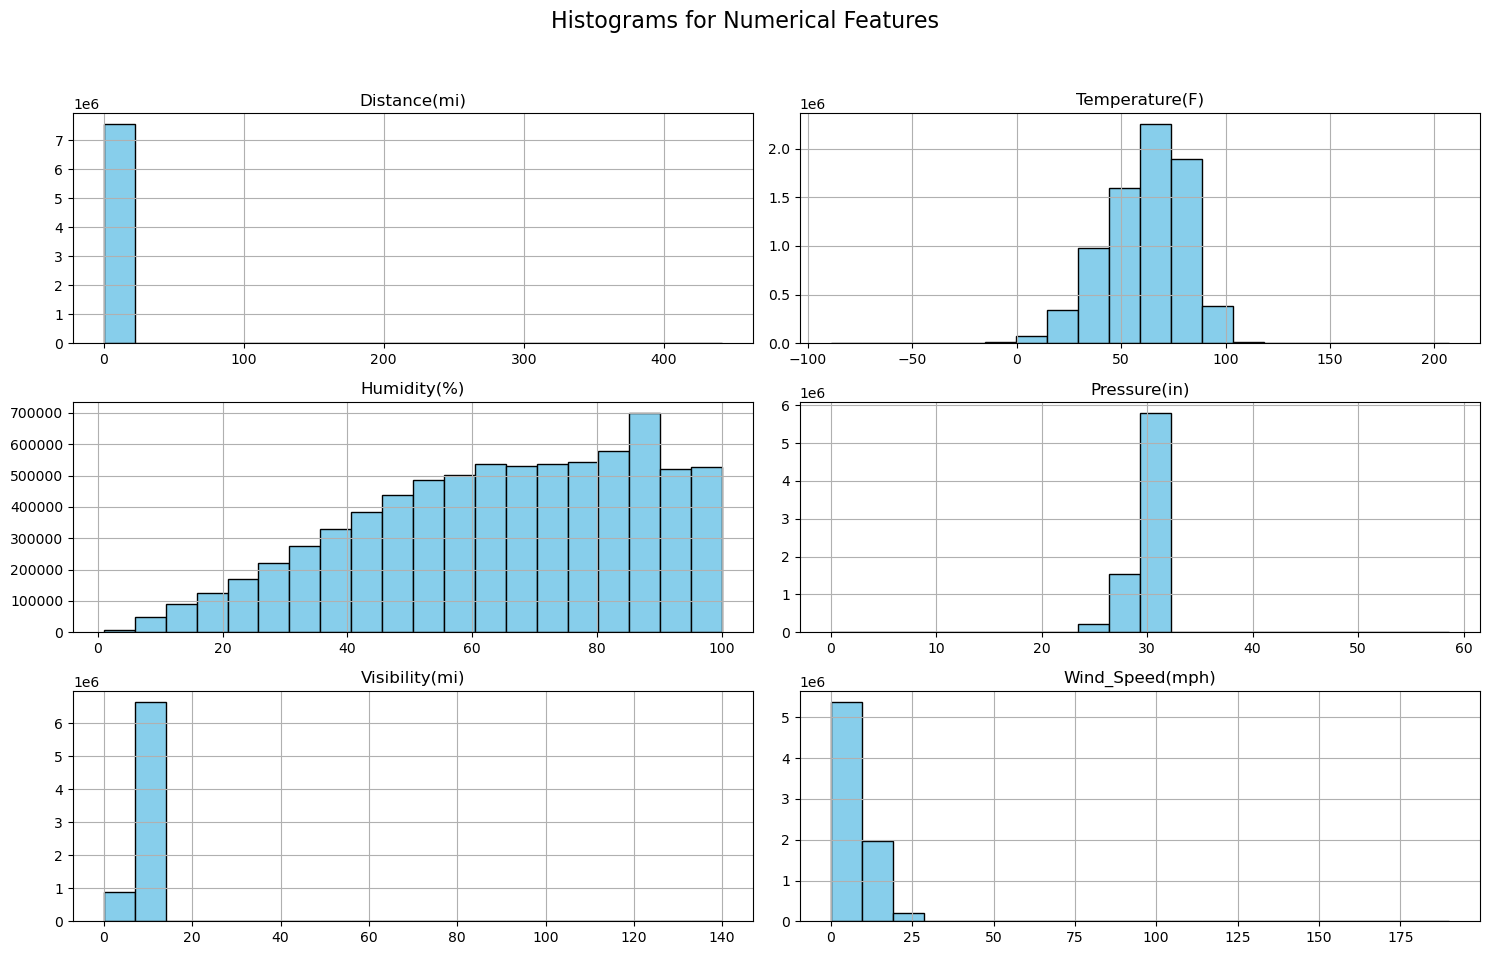

In [31]:
numerical_columns = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
df[numerical_columns].hist(bins=20, figsize=(15, 10), layout=(3, 2), color="skyblue", edgecolor="black")
plt.suptitle("Histograms for Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [33]:
for col in numerical_columns:
    print(f"Descriptive statistics for {col}:\n")
    print(df[col].describe())
    print("\n")

Descriptive statistics for Distance(mi):

count    7.549676e+06
mean     5.569427e-01
std      1.761223e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.900000e-02
75%      4.600000e-01
max      4.417500e+02
Name: Distance(mi), dtype: float64


Descriptive statistics for Temperature(F):

count    7.549676e+06
mean     6.170337e+01
std      1.897934e+01
min     -8.900000e+01
25%      4.900000e+01
50%      6.400000e+01
75%      7.600000e+01
max      2.070000e+02
Name: Temperature(F), dtype: float64


Descriptive statistics for Humidity(%):

count    7.549676e+06
mean     6.482910e+01
std      2.278883e+01
min      1.000000e+00
25%      4.800000e+01
50%      6.700000e+01
75%      8.400000e+01
max      1.000000e+02
Name: Humidity(%), dtype: float64


Descriptive statistics for Pressure(in):

count    7.549676e+06
mean     2.953978e+01
std      1.002665e+00
min      2.000000e-02
25%      2.937000e+01
50%      2.986000e+01
75%      3.003000e+01
max      5.863000e+01
Name: Pressure(

<h4>Some Ambiguous Observations </h4>

<p> 1. The highest distance(mi) is approximately 441, which is way to high

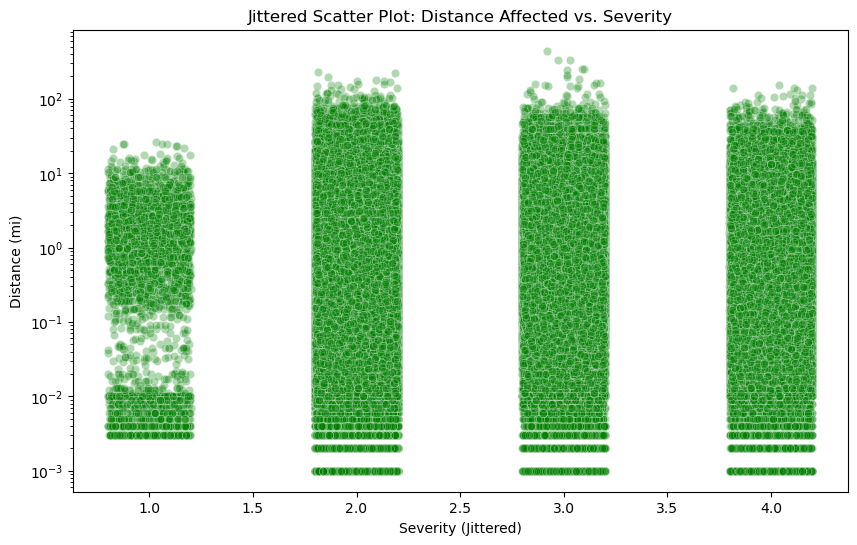

In [38]:
df['Severity_Jittered'] = df['Severity'] + np.random.uniform(-0.2, 0.2, df.shape[0])

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Severity_Jittered', y='Distance(mi)', data=df, alpha=0.3, color='green')
plt.title('Jittered Scatter Plot: Distance Affected vs. Severity')
plt.xlabel('Severity (Jittered)')
plt.ylabel('Distance (mi)')
plt.yscale('log')
plt.show()

In [39]:
distance_summary = df.groupby('Severity')['Distance(mi)'].agg(['mean', 'median', 'max', 'count']).reset_index()
print("Distance affected summary by severity:\n", distance_summary)

Distance affected summary by severity:
    Severity      mean  median         max    count
0         1  0.113851   0.000   25.889999    66406
1         2  0.559848   0.066  227.210007  6017935
2         3  0.421686   0.000  441.750000  1268675
3         4  1.490205   0.474  152.543000   196660


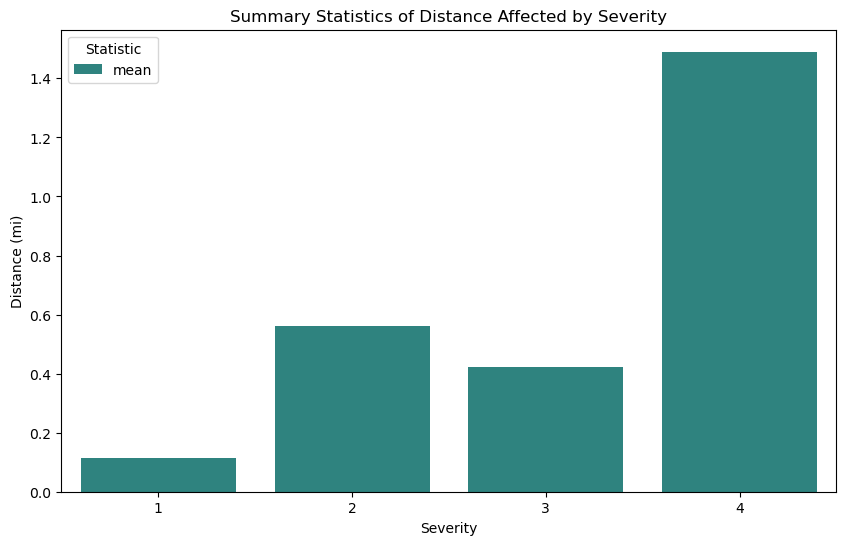

In [42]:
distance_summary_melted = distance_summary.melt(id_vars='Severity', value_vars=['mean'],
                                                var_name='Statistic', value_name='Distance(mi)')

plt.figure(figsize=(10, 6))
sns.barplot(x='Severity', y='Distance(mi)', hue='Statistic', data=distance_summary_melted, palette='viridis')
plt.title('Summary Statistics of Distance Affected by Severity')
plt.xlabel('Severity')
plt.ylabel('Distance (mi)')
plt.legend(title='Statistic')
plt.show()

<h2> Observation </h2>

<p> 1. Higher The severity of the accident, more likely a greater stretch of traffic is affected </p>

<b> Exploring Road Infrastructure Features

In [46]:
traffic_features = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

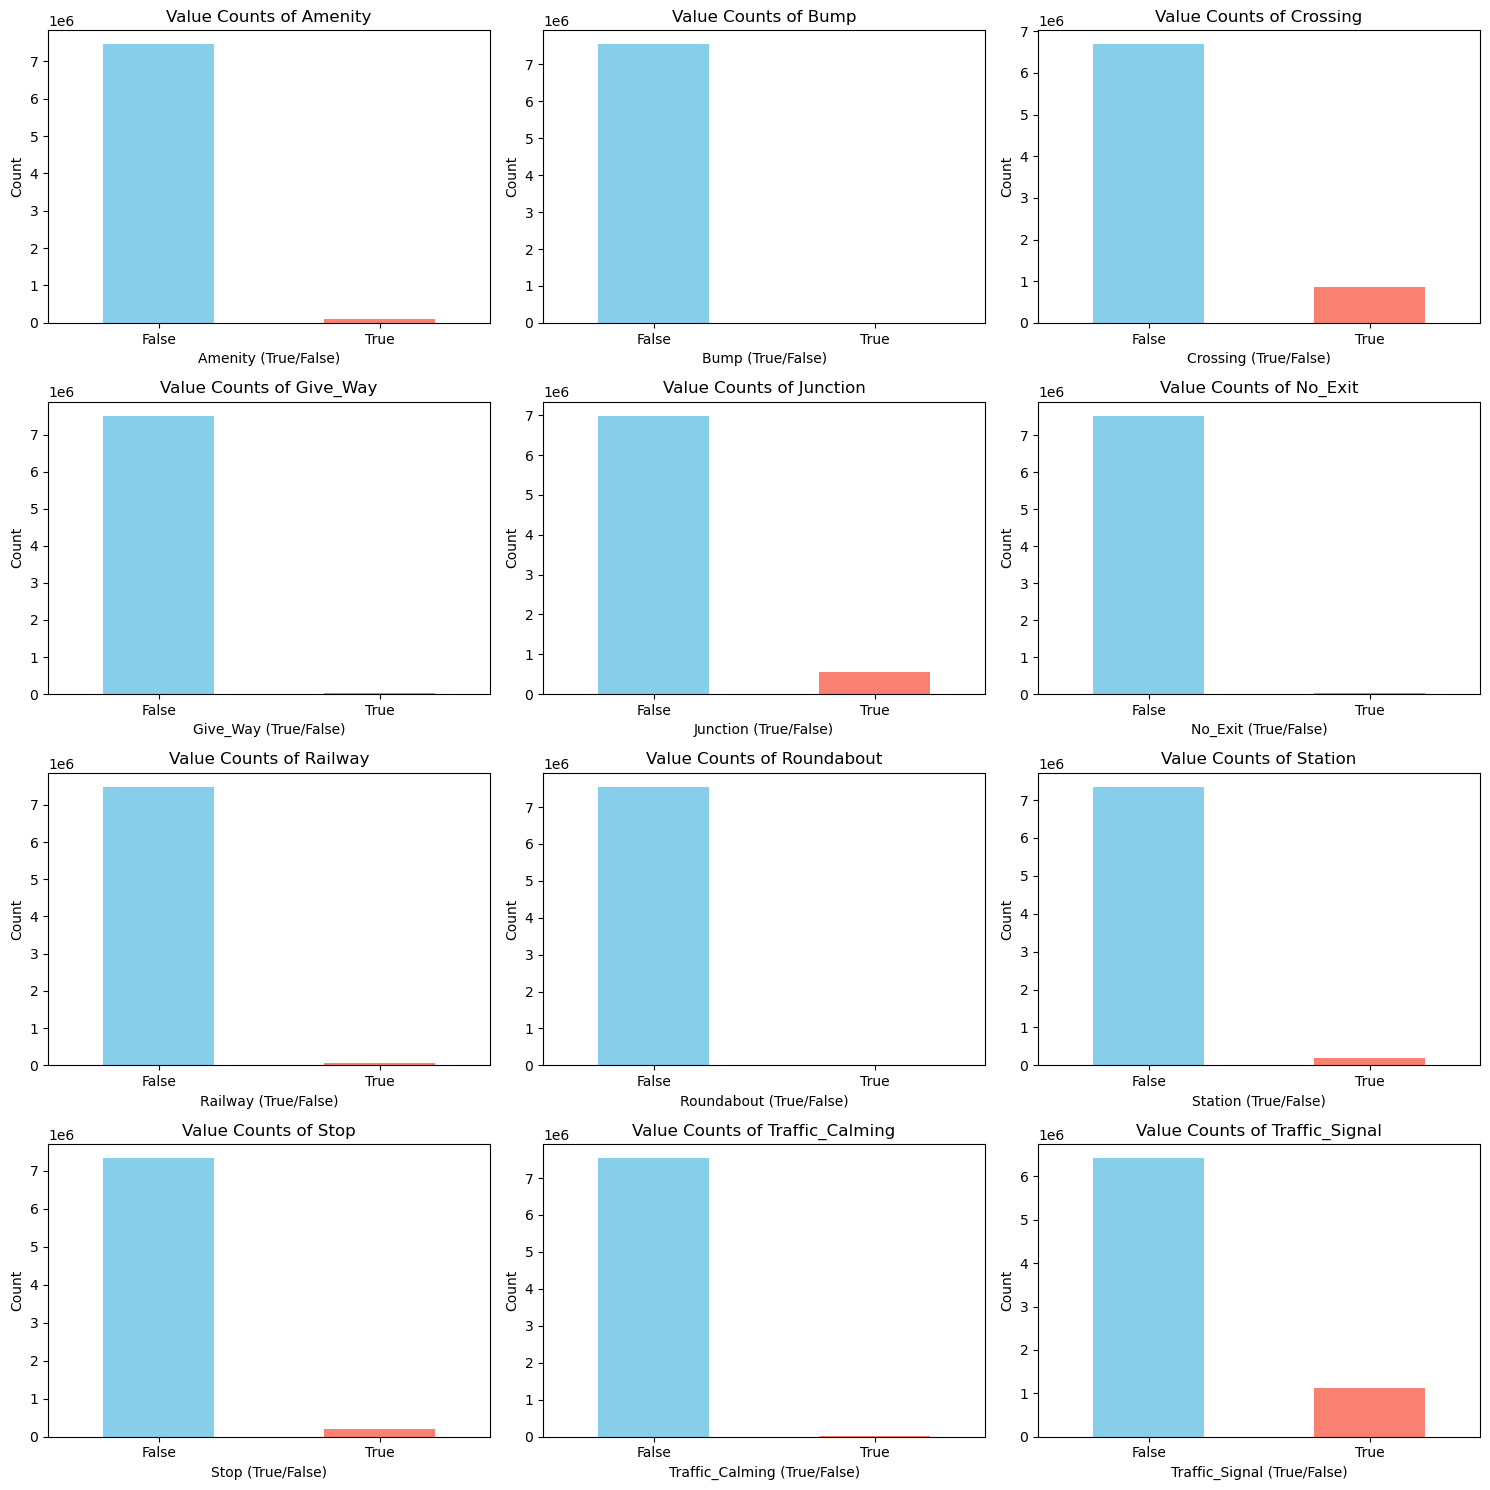

In [48]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
axes = axes.flatten() 


for i, feature in enumerate(traffic_features):
    df[feature].value_counts().plot(kind='bar', ax=axes[i], color=['skyblue', 'salmon'])
    axes[i].set_title(f'Value Counts of {feature}')
    axes[i].set_xlabel(f'{feature} (True/False)')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'], rotation=0)

plt.tight_layout()
plt.show()

In [50]:
for each_feature in traffic_features :
    print("For ", each_feature)
    print(df[each_feature].value_counts())
    print()

For  Amenity
Amenity
False    7455182
True       94494
Name: count, dtype: int64

For  Bump
Bump
False    7546224
True        3452
Name: count, dtype: int64

For  Crossing
Crossing
False    6688923
True      860753
Name: count, dtype: int64

For  Give_Way
Give_Way
False    7514157
True       35519
Name: count, dtype: int64

For  Junction
Junction
False    6992002
True      557674
Name: count, dtype: int64

For  No_Exit
No_Exit
False    7530409
True       19267
Name: count, dtype: int64

For  Railway
Railway
False    7484730
True       64946
Name: count, dtype: int64

For  Roundabout
Roundabout
False    7549432
True         244
Name: count, dtype: int64

For  Station
Station
False    7351482
True      198194
Name: count, dtype: int64

For  Stop
Stop
False    7340432
True      209244
Name: count, dtype: int64

For  Traffic_Calming
Traffic_Calming
False    7542214
True        7462
Name: count, dtype: int64

For  Traffic_Signal
Traffic_Signal
False    6425599
True     1124077
Name: count, 

In [52]:
high_count_features = ['Crossing', 'Junction', 'Stop', 'Traffic_Signal']

In [54]:
junction_severity = df.groupby(['Junction', 'Severity']).size().unstack(fill_value=0)
print(junction_severity)
print("\n")

Severity      1        2        3       4
Junction                                 
False     63319  5612573  1139375  176735
True       3087   405362   129300   19925




In [56]:
boolean_columns = df.select_dtypes(include=['bool']).columns
df[boolean_columns] = df[boolean_columns].astype(int)

In [58]:
df.drop(columns=["Severity_Jittered"], inplace = True)

In [59]:
numeric_columns = list(df.select_dtypes(include=['int64']).columns) + list(df.select_dtypes(include=['float64']).columns)

In [62]:
correlation_matrix = df[numeric_columns].corr()

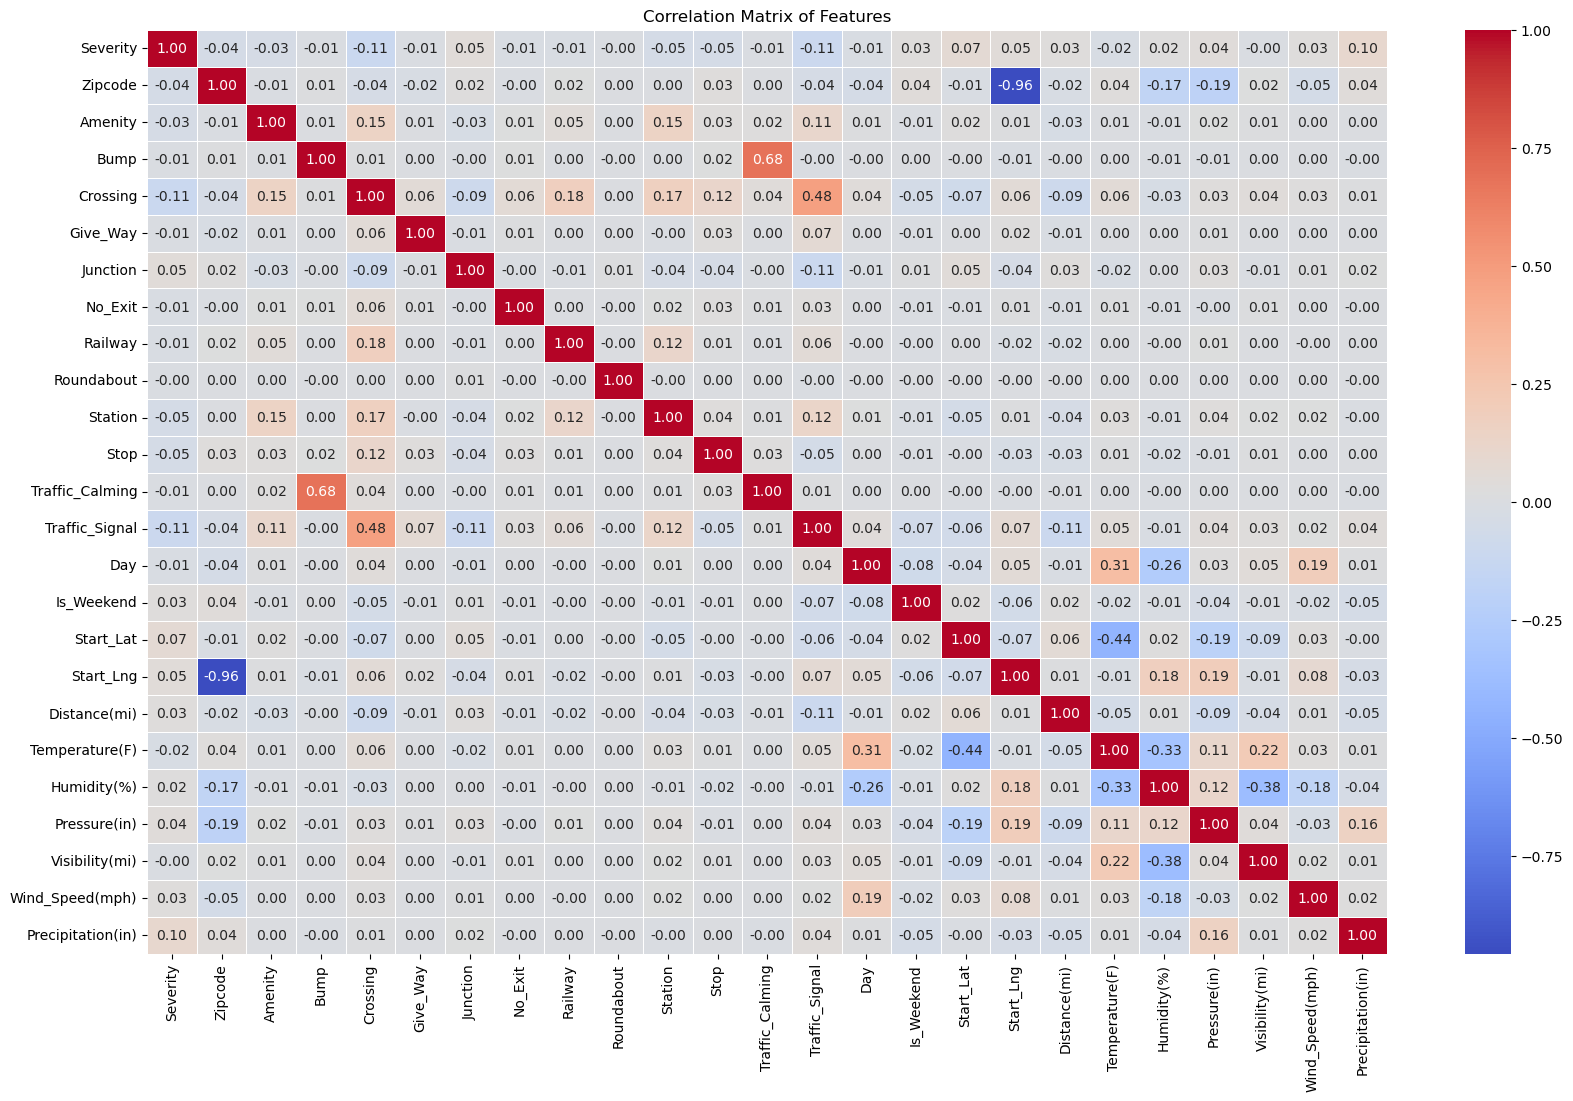

In [66]:
plt.figure(figsize=(20, 12))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)


plt.title('Correlation Matrix of Features')
plt.show()

<h2> Q.1 Were there negative impacts of the COVID-19 lockdown on traffic accidents?</h2>

In [69]:
monthly_counts = df.groupby(['Year', 'month']).size().reset_index(name='Counts')

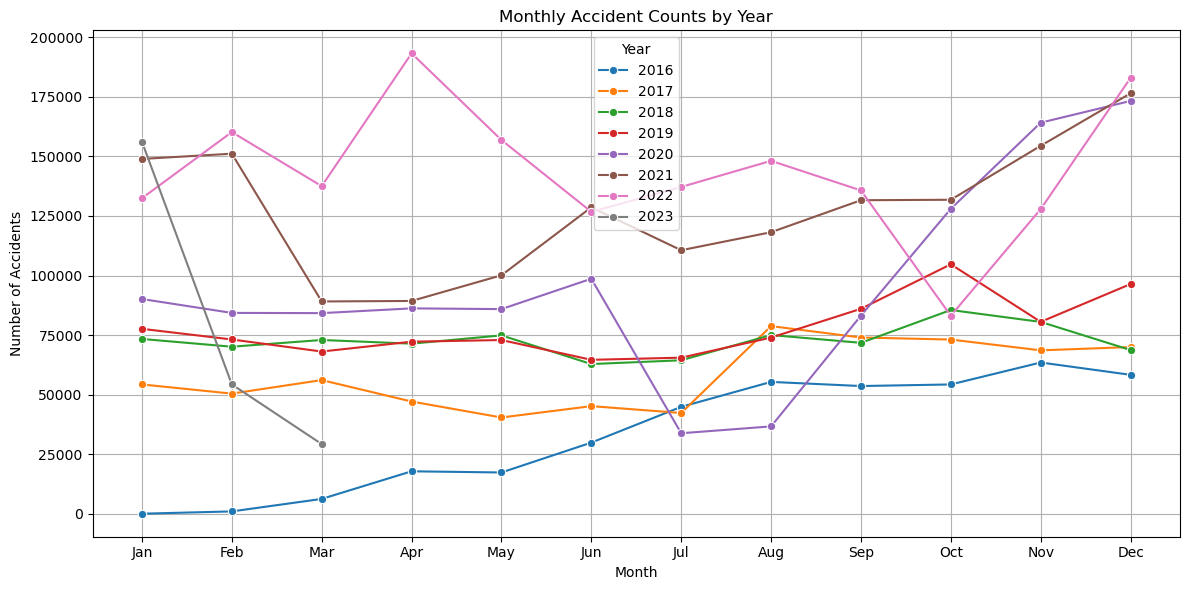

In [71]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='month', y='Counts', hue='Year', marker='o', palette='tab10')

plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.title('Monthly Accident Counts by Year')
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.legend(title='Year')
plt.grid(True)
# plt.gcf().savefig('Time_vs_Acc_Counts.png')
plt.tight_layout()

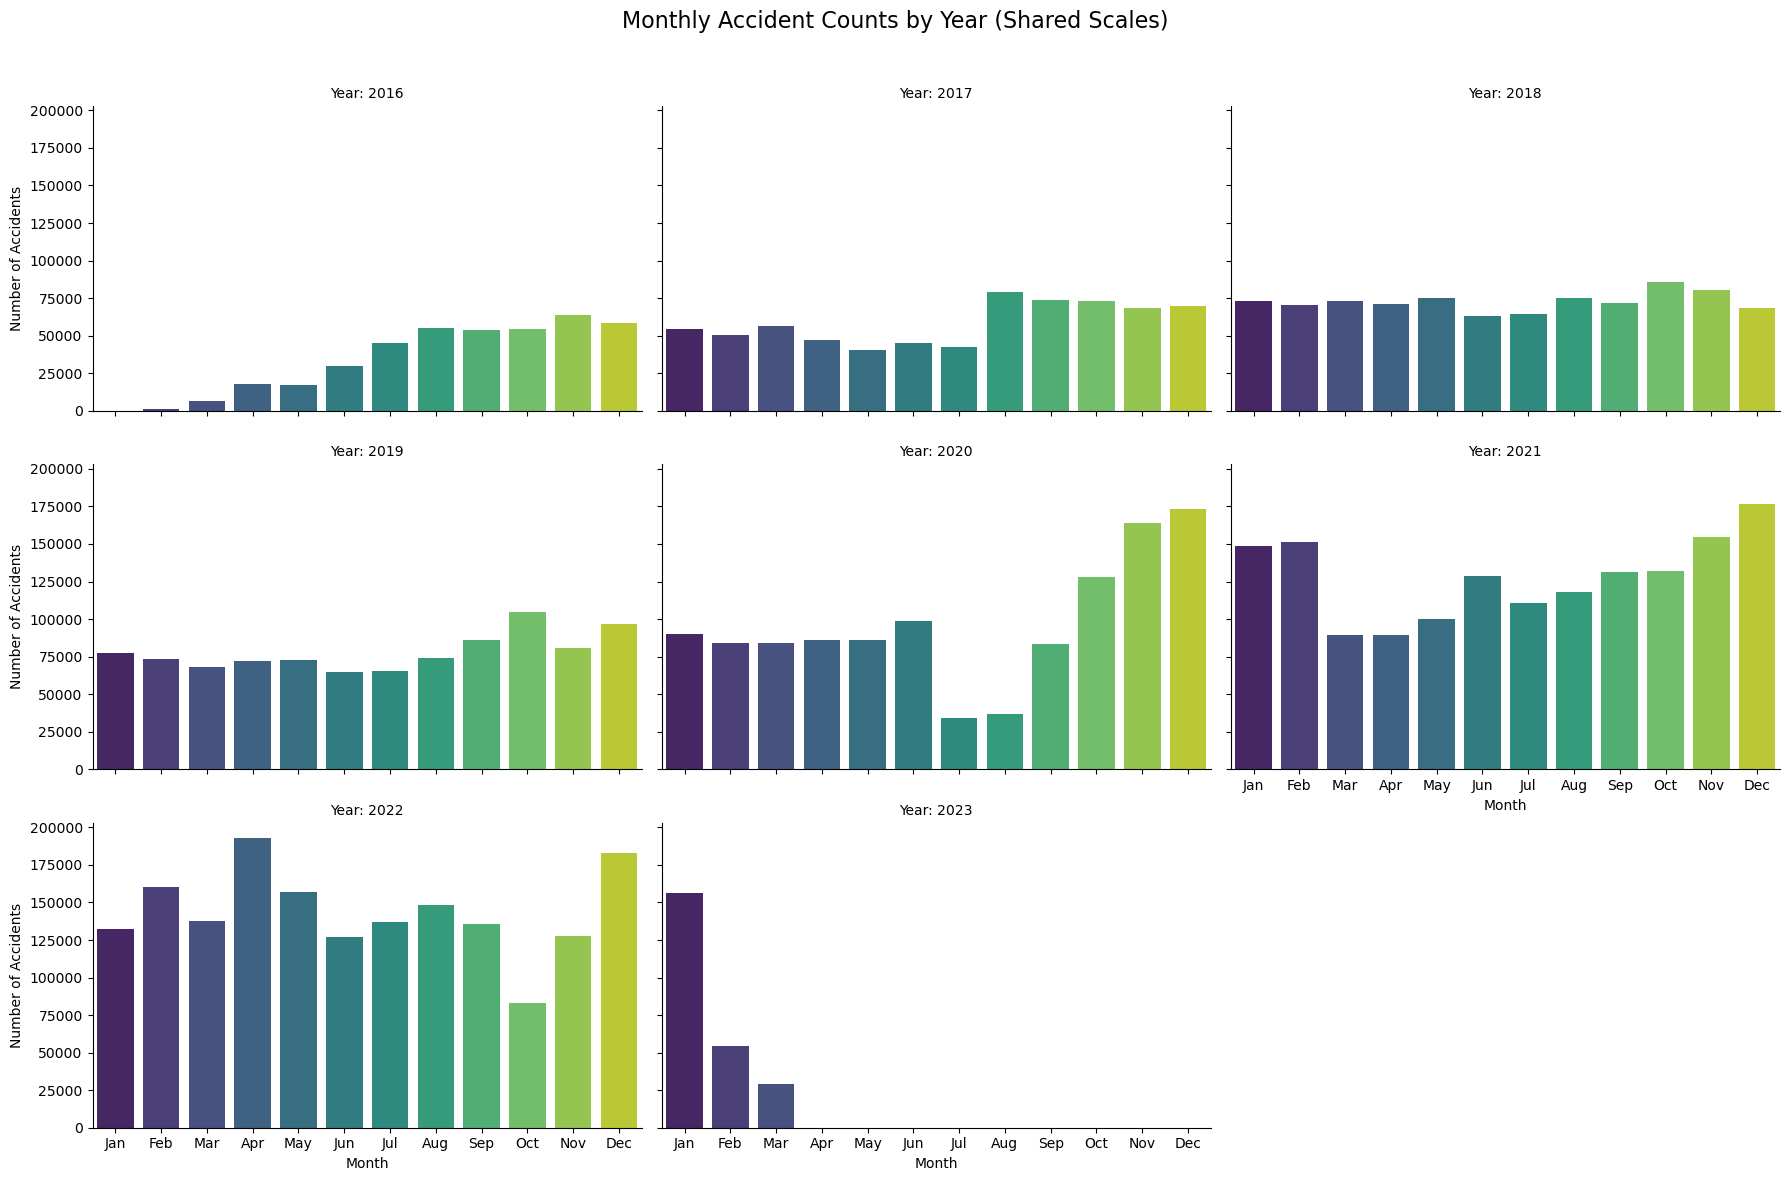

In [73]:
g = sns.FacetGrid(
    monthly_counts, 
    col='Year', 
    col_wrap=3, 
    height=4, 
    aspect=1.5, 
    sharey=True  
)
g.map(sns.barplot, 'month', 'Counts', order=range(1, 13), palette='viridis')


g.set_titles("Year: {col_name}")
g.set_axis_labels("Month", "Number of Accidents")
g.set(xticks=range(12), xticklabels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Monthly Accident Counts by Year (Shared Scales)", fontsize=16)


# g.savefig("Monthly_Acc_Counts.png", dpi=300, bbox_inches = 'tight')
plt.show()

<h2> Observation  </h2>

<p> Accidents Counts Rised Significantly after the covid</p>

Filter the data into three periods: pre-lockdown, during lockdown, and post-lockdown.

In [77]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])

In [79]:
pre_lockdown = df[df['Start_Time'] < '2020-03-01']
during_lockdown = df[(df['Start_Time'] >= '2020-03-01') & (df['Start_Time'] <= '2020-06-30')]
post_lockdown = df[df['Start_Time'] > '2020-06-30']

Plot the severity distribution for each period

In [81]:
pre_lockdown['Period'] = 'Pre-lockdown'
during_lockdown['Period'] = 'During lockdown'
post_lockdown['Period'] = 'Post-lockdown'
combined_df = pd.concat([pre_lockdown, during_lockdown, post_lockdown])

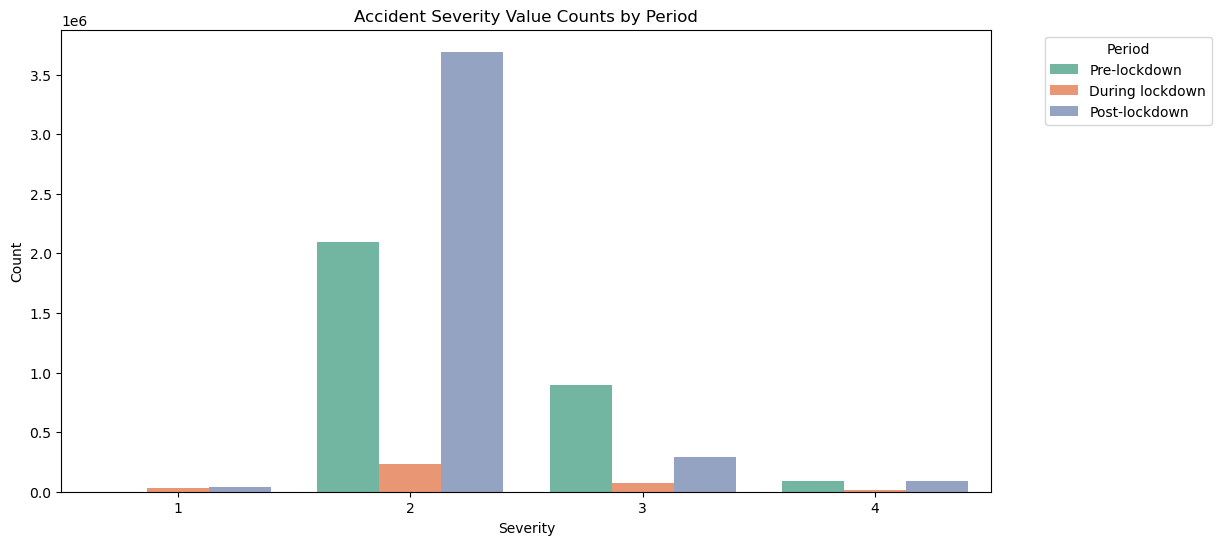

In [84]:
plt.figure(figsize=(12, 6))
sns.countplot(data=combined_df, x='Severity', hue='Period', palette='Set2')
plt.title('Accident Severity Value Counts by Period')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.savefig("Severity_Covid_Trends.png", bbox_inches='tight', dpi=300)
plt.show()

<h2> Observation </h2>

<p> Severity of Accidents have decreased post covid</p>

Accident Severity by Location (Junctions, Roundabouts, etc.)

In [87]:
location_features = ['Junction', 'Roundabout', 'Station', 'Traffic_Signal', 'Stop']

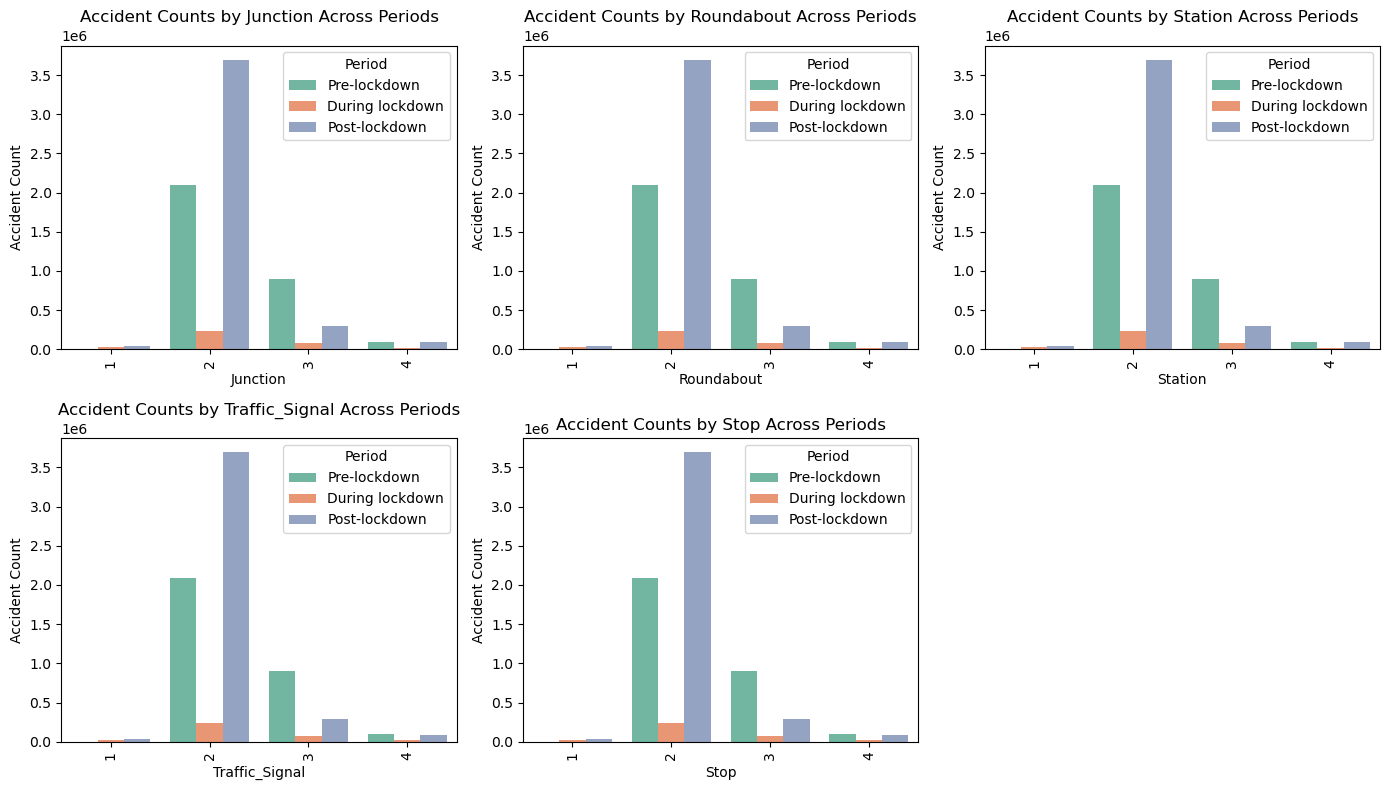

In [90]:
plt.figure(figsize=(14, 8))

for i, feature in enumerate(location_features, 1):
    plt.subplot(2, 3, i) 
    sns.countplot(data=combined_df, x='Severity', hue='Period', palette='Set2')
    plt.title(f'Accident Counts by {feature} Across Periods')
    plt.xlabel(f'{feature}')
    plt.ylabel('Accident Count')
    plt.xticks(rotation=90)

plt.tight_layout()
# plt.gcf().savefig("Road_Feature_Covid.png")
plt.show()

Covid Effect State Wise

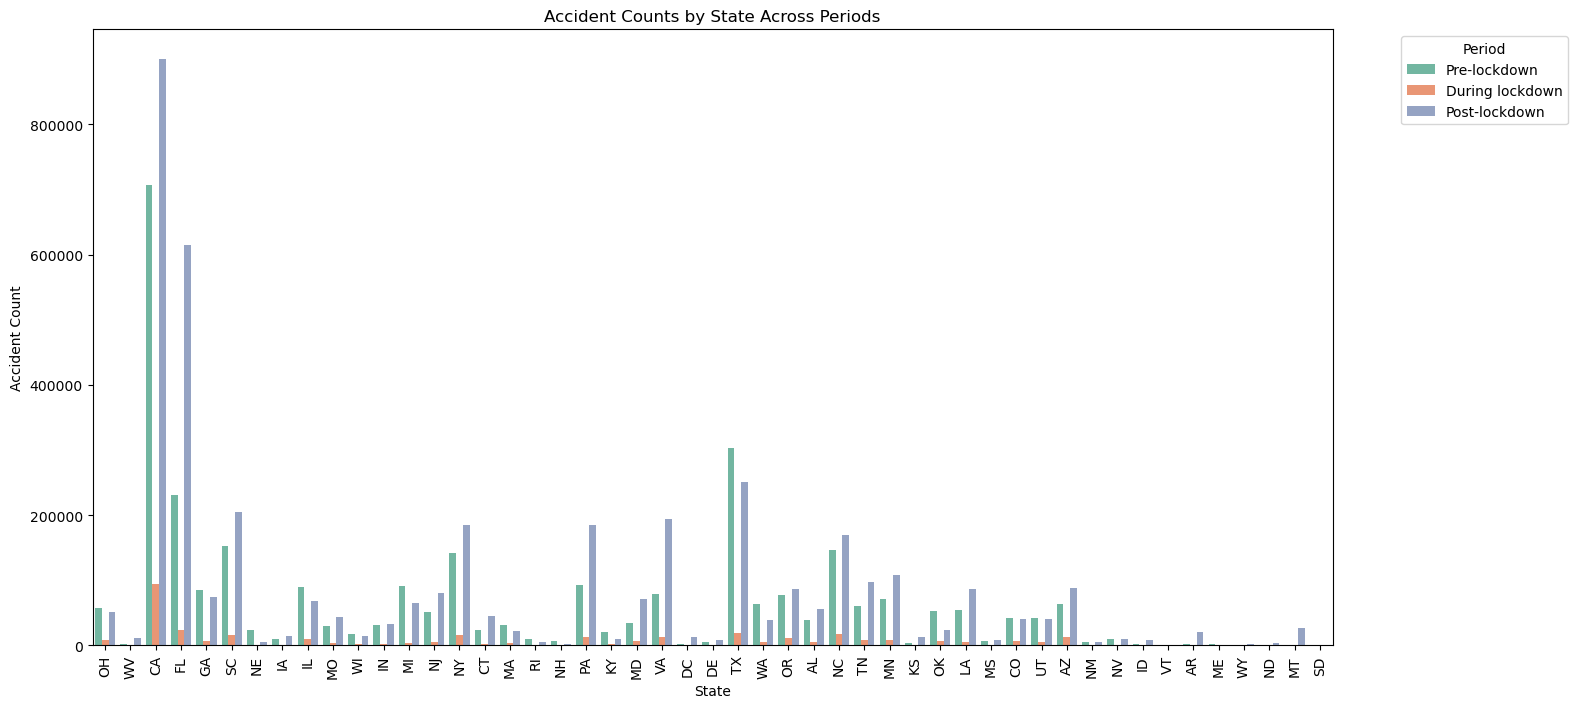

In [93]:
plt.figure(figsize=(16, 8))
sns.countplot(data=combined_df, x='State', hue='Period', palette='Set2')
plt.title('Accident Counts by State Across Periods')
plt.xlabel('State')
plt.ylabel('Accident Count')
plt.xticks(rotation=90)
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.gcf().savefig("statewise_covid.png", bbox_inches='tight', dpi = 300)
plt.show()

<h2> Observation </h2>

Only in Certain States accident rate droped significantly post covid: <br>
1. Texas
 

Accident Frequency by Day of the Week

In [97]:
weekly_counts = combined_df.groupby(['Day_of_Week', 'Period']).size().reset_index(name='Accident Count')

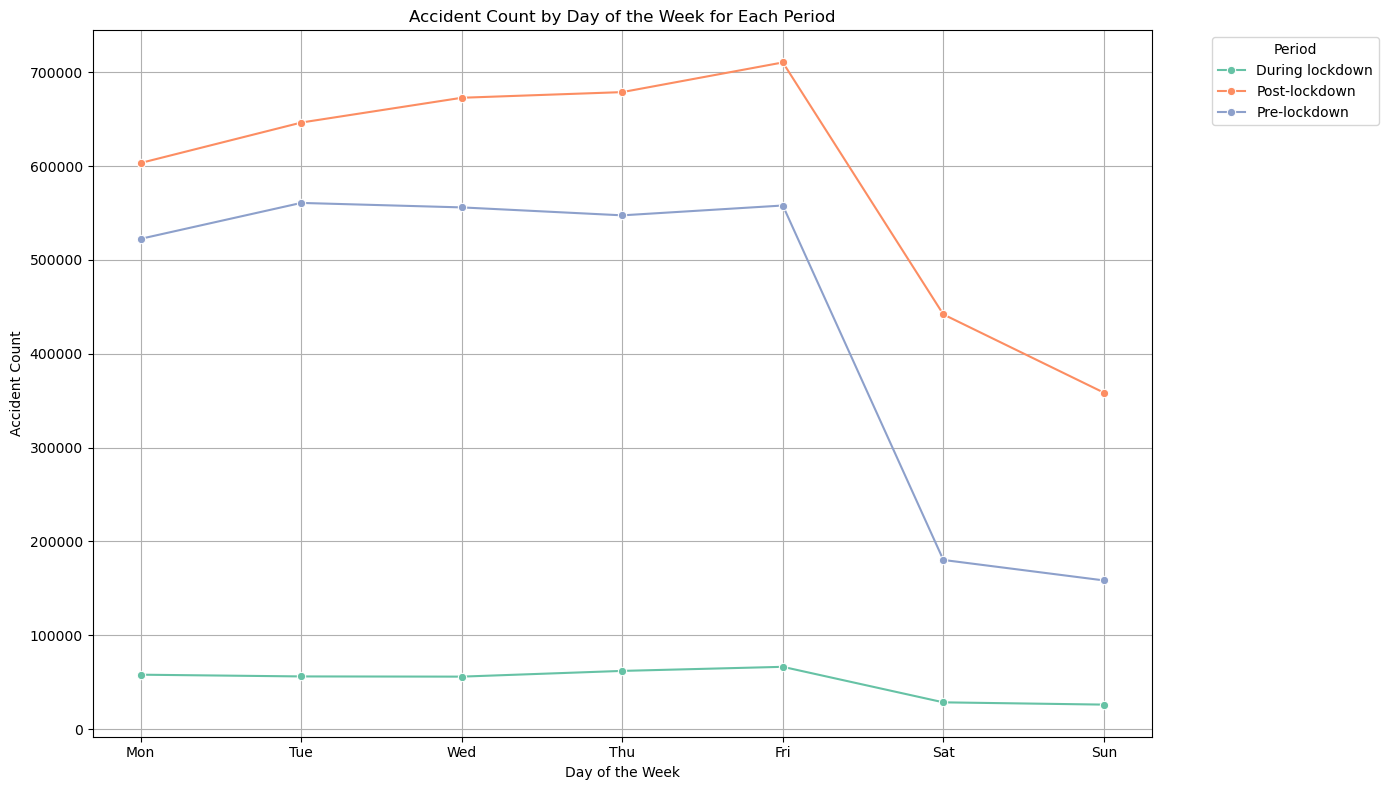

In [98]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=weekly_counts, x='Day_of_Week', y='Accident Count', hue='Period', marker='o', palette='Set2')
plt.title('Accident Count by Day of the Week for Each Period')
plt.xlabel('Day of the Week')
plt.ylabel('Accident Count')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
# plt.gcf().savefig("DayOfWeek_Covid.png")
plt.show()

<h2> Observation </h2>

<p> Irrespective of covid, fridays have always recorded more accidents </p>

In [102]:
hourly_counts = combined_df.groupby(['Hour_of_Day', 'Period']).size().reset_index(name='Accident Count')

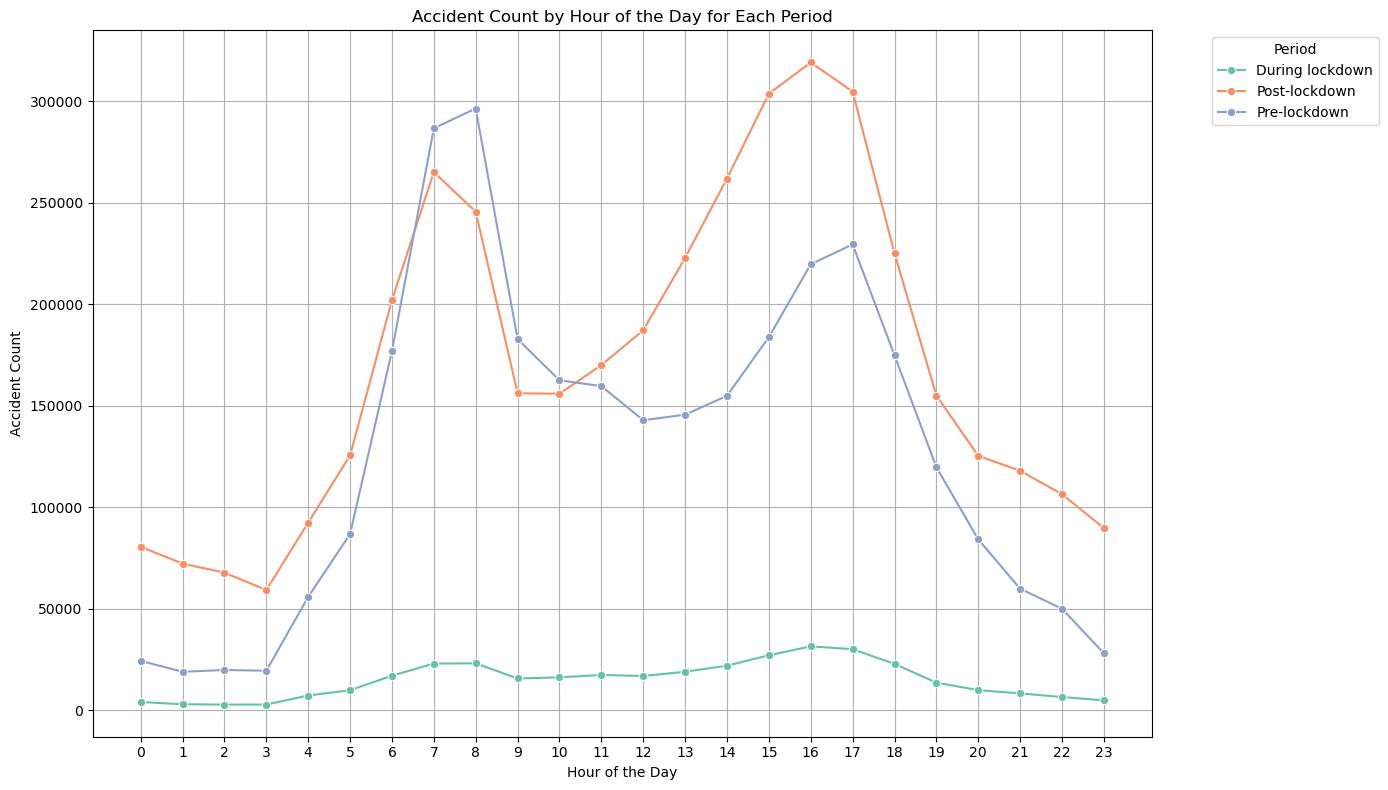

In [103]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=hourly_counts, x='Hour_of_Day', y='Accident Count', hue='Period', marker='o', palette='Set2')
plt.title('Accident Count by Hour of the Day for Each Period')
plt.xlabel('Hour of the Day')
plt.ylabel('Accident Count')
plt.xticks(range(24))  # Show hours on the x-axis
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
# plt.gcf().savefig("HourOfDay_Covid.png")
plt.show()

<h2> Observations </h2>

1. Before Lockdown, Most of the accidents took place around 7-8 AM
2. During Lockdown, Most of the accidents took place around 4 - 5 PM
3. After Lockdown, Most of the accidents took place around 4 - 5 PM

In [107]:
categorical_features = ['Temperature_Category', 'Distance_Category', 'Humidity_Category', 
                        'Pressure_Category', 'Wind_Speed_Category', 'Precipitation_Category', 'Visibility_Category']

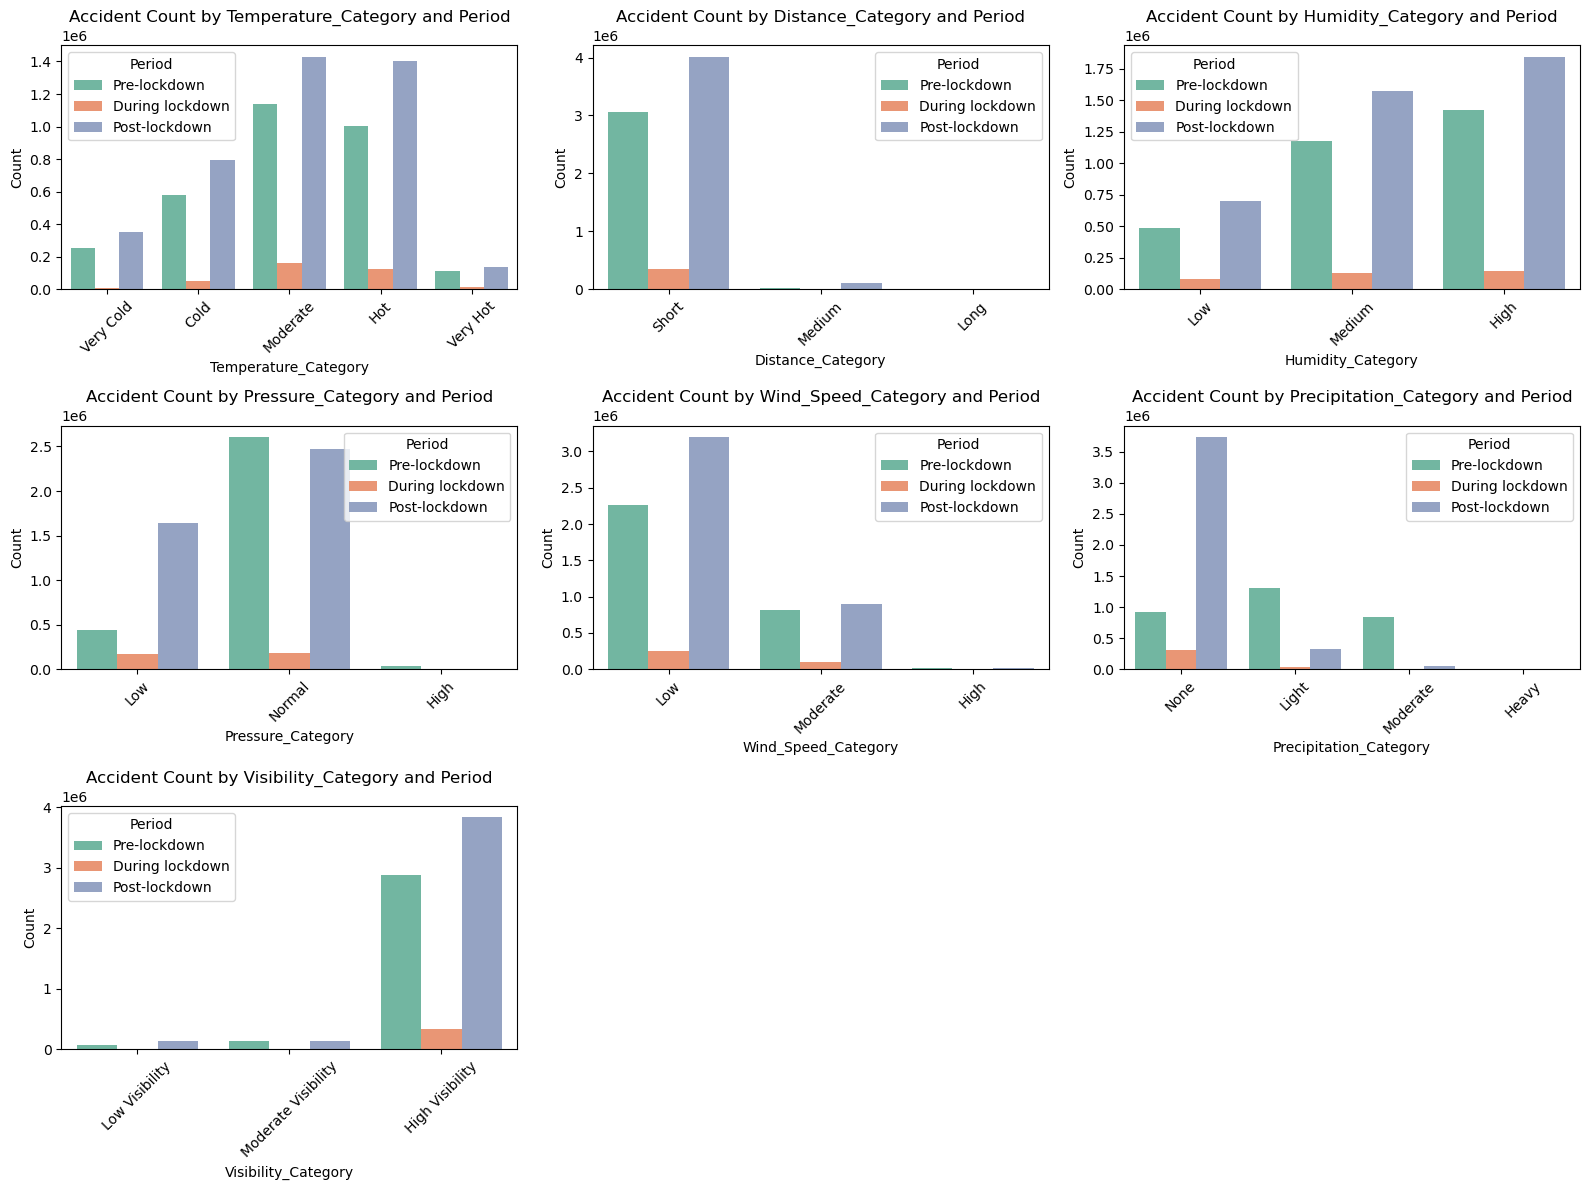

In [109]:
plt.figure(figsize=(16, 12))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=combined_df, x=feature, hue='Period', palette='Set2')
    plt.title(f'Accident Count by {feature} and Period')
    plt.xlabel(f'{feature}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
# plt.gcf().savefig("Weather_Binned_Covid.png")
plt.show()

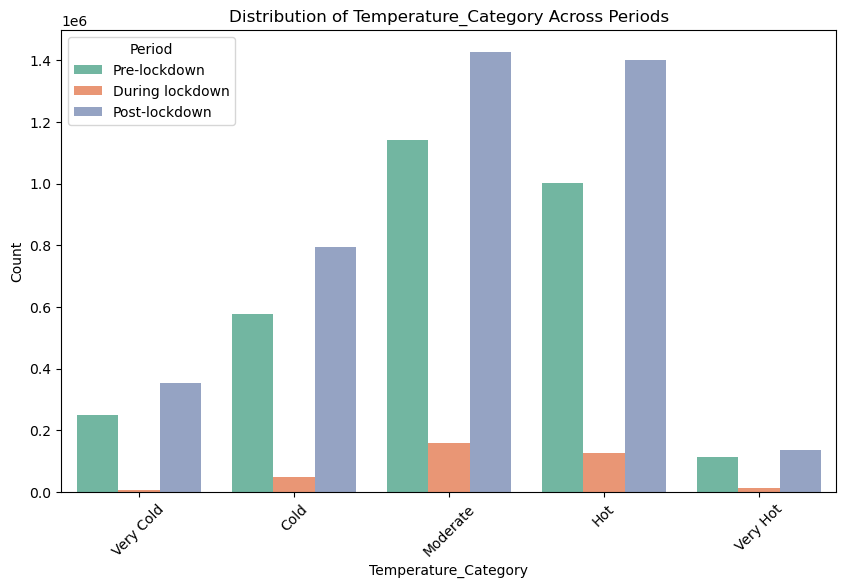

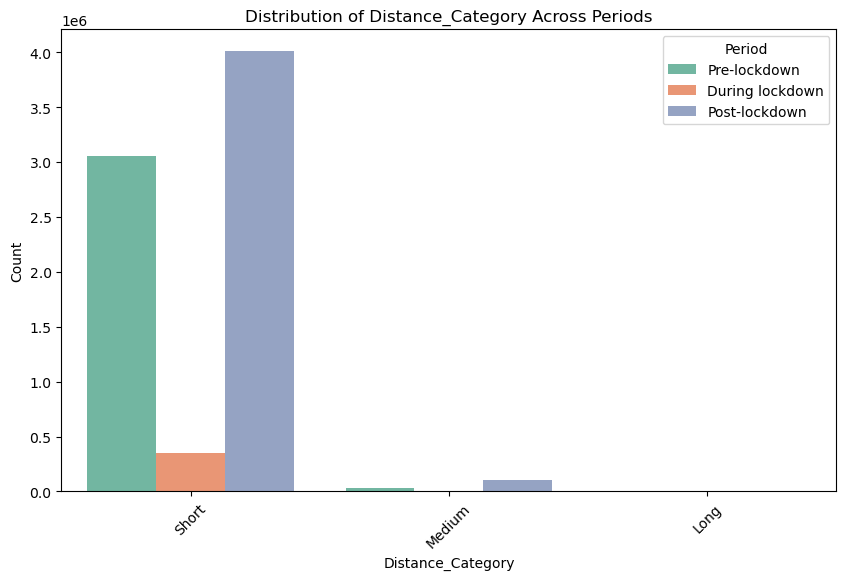

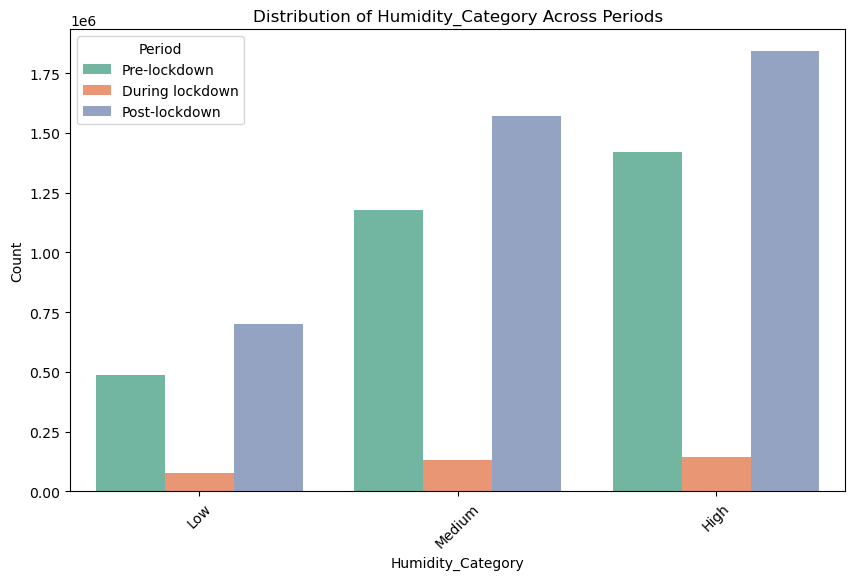

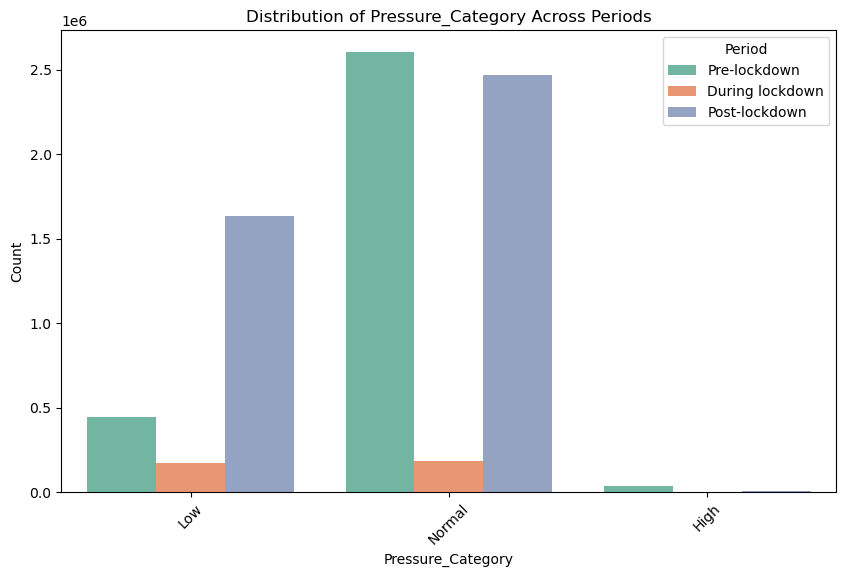

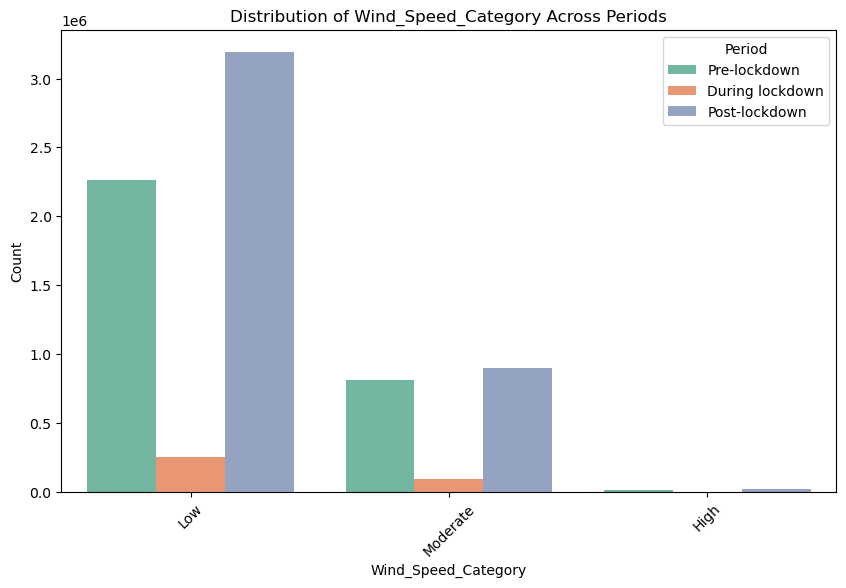

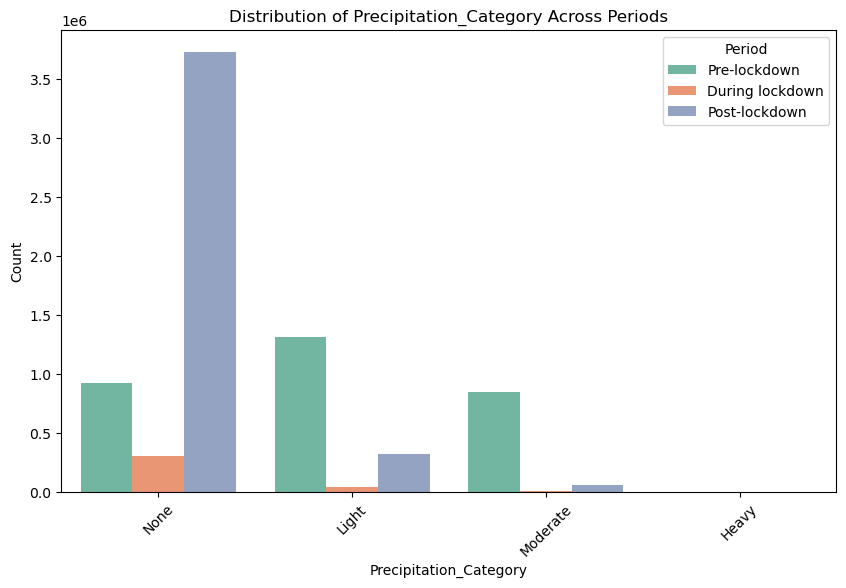

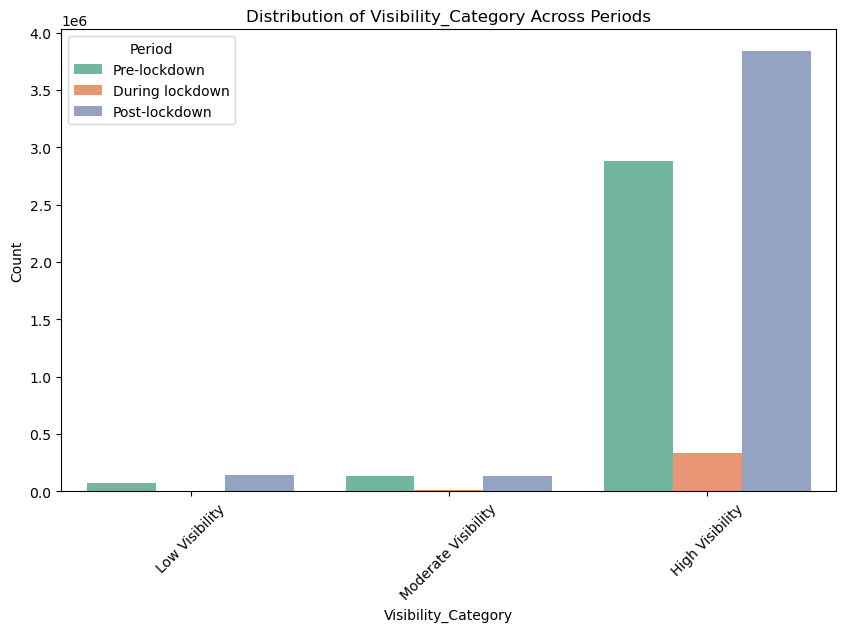

In [110]:
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=combined_df, x=feature, hue='Period', palette='Set2', dodge=True)
    plt.title(f'Distribution of {feature} Across Periods')
    plt.xlabel(f'{feature}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

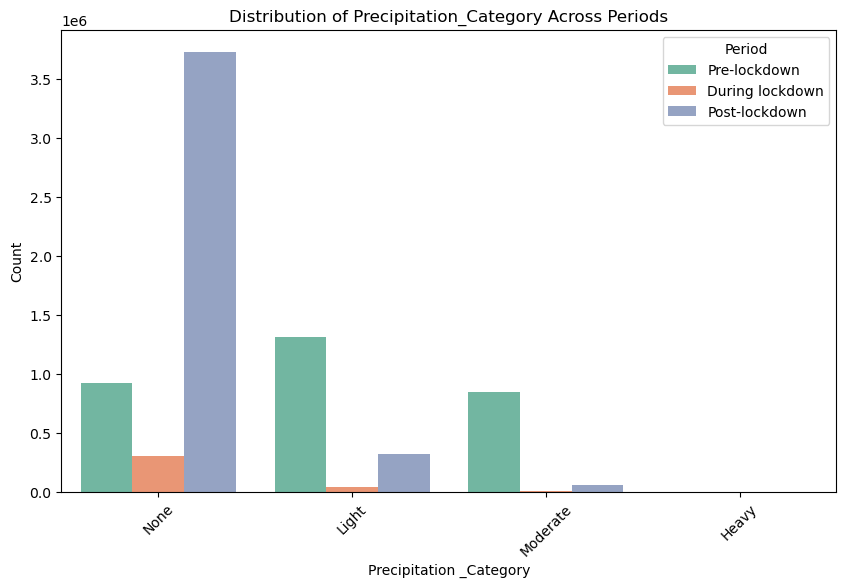

In [112]:
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x= 'Precipitation_Category', hue='Period', palette='Set2', dodge=True)
plt.title('Distribution of Precipitation_Category Across Periods')
plt.xlabel('Precipitation _Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
# plt.gcf().savefig('precipitation_binned_covid.png')
plt.show()

<h2> Observation </h2>

1. Post Covid, Most Accidents were recorded when there was no precipitation, before covid, accidents were recorded in range no to moderate rainfall

<h4> Accident Duration </h4>

In [118]:
combined_df['Start_Time'] = pd.to_datetime(combined_df['Start_Time'])
combined_df['End_Time'] = pd.to_datetime(combined_df['End_Time'])

In [120]:
combined_df['Accident_Duration'] = (combined_df['End_Time'] - combined_df['Start_Time']).dt.total_seconds() / 60

In [122]:
mean_duration_by_period = combined_df.groupby('Period')['Accident_Duration'].mean().reset_index()


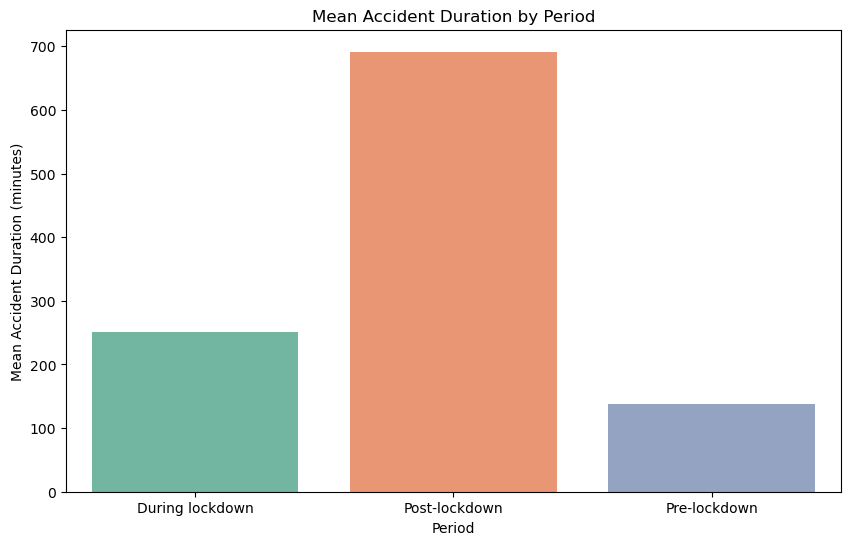

In [123]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Period', y='Accident_Duration', data=mean_duration_by_period, palette='Set2')
plt.title('Mean Accident Duration by Period')
plt.xlabel('Period')
plt.ylabel('Mean Accident Duration (minutes)')
plt.show()

In [126]:
location_features = ['Roundabout', 'Junction', 'Traffic_Signal', 'Railway', 'Station', 'Stop']

In [127]:
period  = combined_df.groupby(by = "Period")

In [128]:
temp = period[location_features].sum()

In [129]:
temp

Roundabout  Junction  Traffic_Signal  Railway  Station  \
Period                                                                    
During lockdown           2     31666           87837     3892     9476   
Post-lockdown           138    269589          427355    31540   108945   
Pre-lockdown            104    256419          608885    29514    79773   

                   Stop  
Period                   
During lockdown    9346  
Post-lockdown    112319  
Pre-lockdown      87579

In [134]:
for each_period in temp.index.values:
    print(f"Most Accidents {each_period} occured at {temp.loc[each_period].idxmax()}")

Most Accidents During lockdown occured at Traffic_Signal
Most Accidents Post-lockdown occured at Traffic_Signal
Most Accidents Pre-lockdown occured at Traffic_Signal


In [136]:
for each_period in temp.index.values:
    print(f"Least Accidents {each_period} occured at {temp.loc[each_period].idxmin()}")

Least Accidents During lockdown occured at Roundabout
Least Accidents Post-lockdown occured at Roundabout
Least Accidents Pre-lockdown occured at Roundabout


<h2> Q2 What conditions influence accidents? Where do the most accidents happen in the US?</h2>

In [139]:
location_features = ['Crossing', 'Junction','Railway','Roundabout','Station','Traffic_Signal']

In [141]:
df_location = df[location_features + ['Severity']]

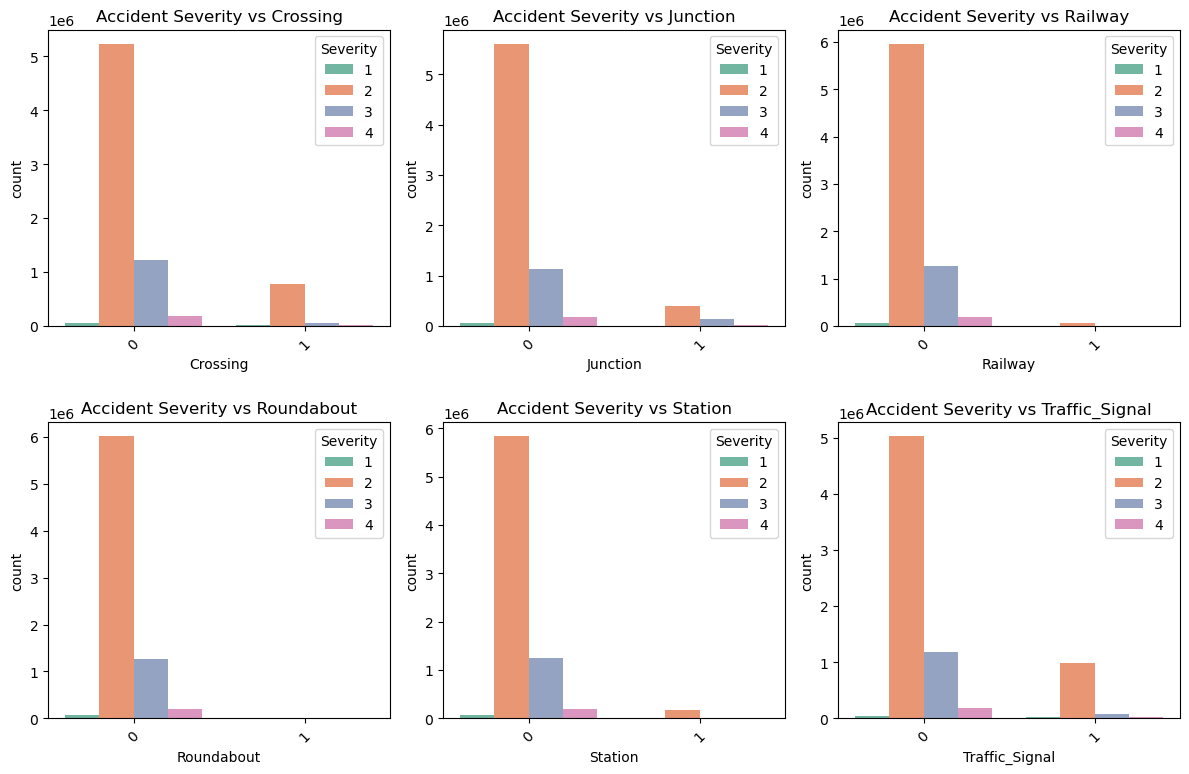

In [142]:
plt.figure(figsize=(12, 8))

for i, feature in enumerate(location_features):
    plt.subplot(2, 3, i+1)
    sns.countplot(x=feature, hue='Severity', data=df_location, palette='Set2')
    plt.title(f"Accident Severity vs {feature}")
    plt.xticks(rotation=45)

plt.tight_layout()
# plt.gcf().savefig('location_features_count.png')
plt.show()

<h2> Observation </h2>

1. Least Accidents Recorded on a Roundabout

In [145]:
road_infrastructure_features = ['Bump', 'Give_Way','No_Exit','Stop','Traffic_Calming']

In [146]:
df_road_infra = df[road_infrastructure_features + ['Severity']]

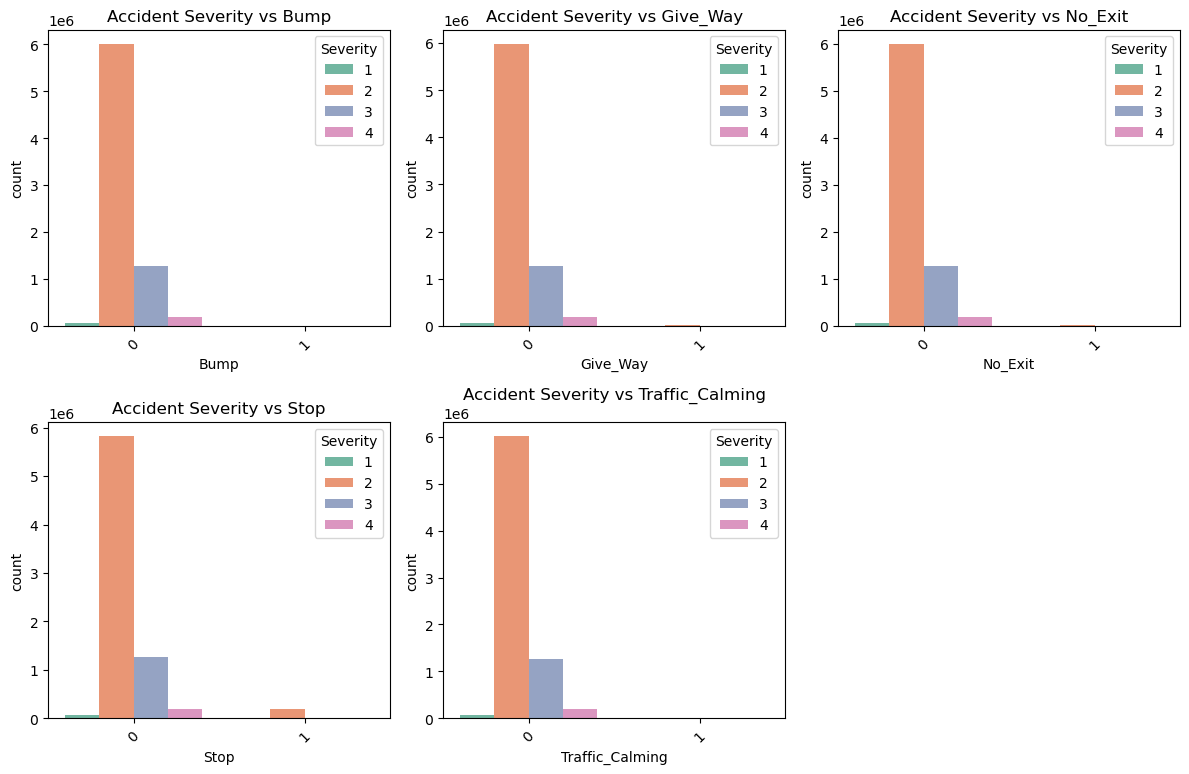

In [147]:
plt.figure(figsize=(12, 8))

for i, feature in enumerate(road_infrastructure_features):
    plt.subplot(2, 3, i+1)
    sns.countplot(x=feature, hue='Severity', data=df_road_infra, palette='Set2')
    plt.title(f"Accident Severity vs {feature}")
    plt.xticks(rotation=45)

plt.tight_layout()
# plt.gcf().savefig('road_features_count.png')
plt.show()

<h4> Observations </h4>

1. Few Accidents Recorded in presence of Bump
2. Few Accidents Recorded in presence of Traffic_Calming

In [154]:
weather_categories = ['Distance_Category','Humidity_Category','Pressure_Category','Wind_Speed_Category','Precipitation_Category','Visibility_Category', 'Temperature_Category']

In [156]:
df_weather = df[weather_categories + ['Severity']]

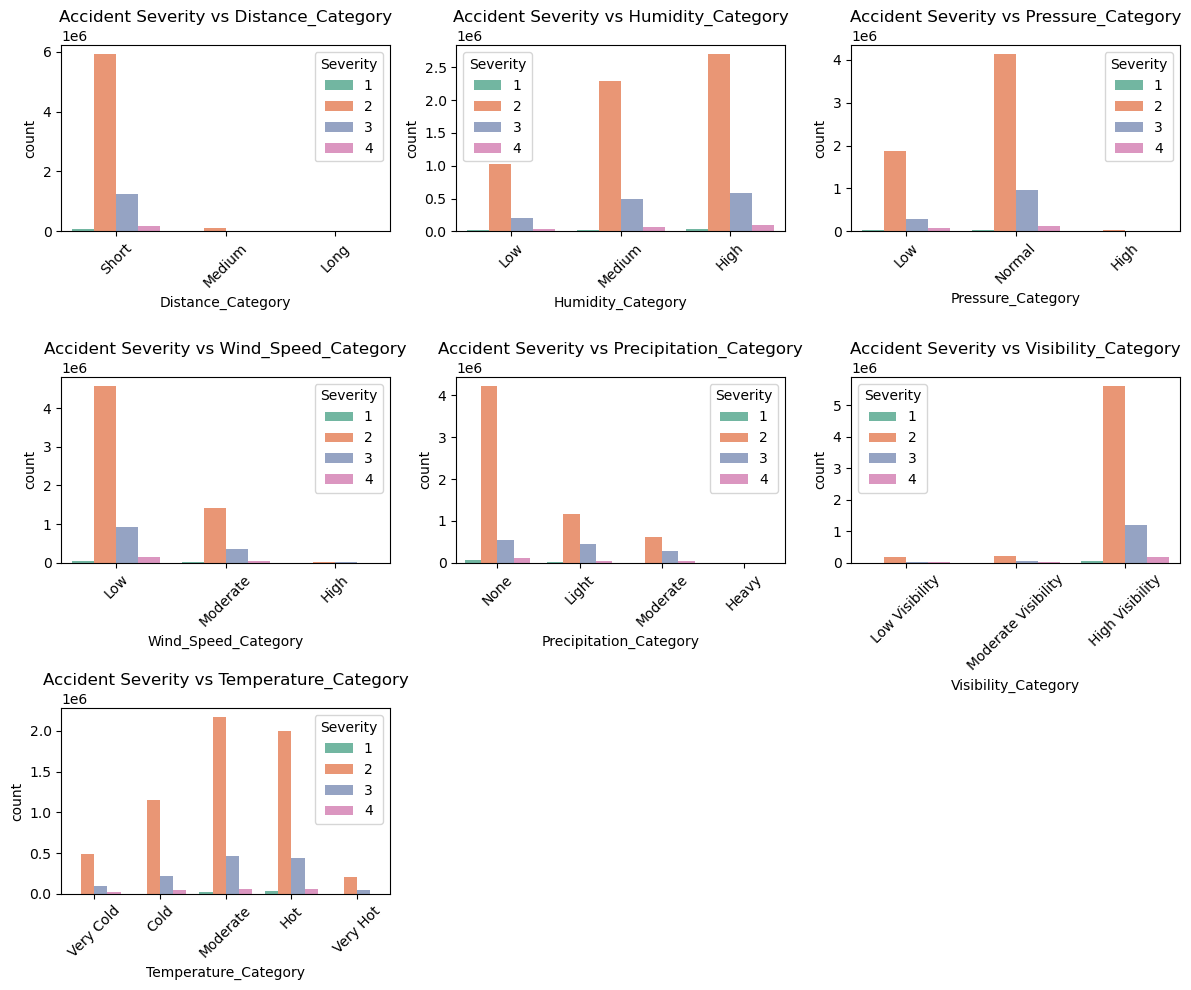

In [157]:
plt.figure(figsize=(12, 10))


for i, feature in enumerate(weather_categories):
    plt.subplot(3, 3, i + 1)  
    sns.countplot(x=feature, hue='Severity', data=df_weather, palette='Set2')
    plt.title(f"Accident Severity vs {feature}")
    plt.xticks(rotation=45)

plt.tight_layout()
# plt.gcf().savefig('weather_features_count.png')
plt.show()

<h2> Observations </h2>

1. Most Accidents occur when Humidity is Medium To High
2. Interestingly, Most Accidents Occur Even When there is High Visibility

In [160]:
target = 'Severity'

<h3> Rules Based on Location Features </h3>

In [163]:
X = df_location[location_features]
y = df_location[target]

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [167]:
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [168]:
y_pred = dt_model.predict(X_test)

In [169]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [172]:
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.7971417331595512
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     13144
           2       0.80      1.00      0.89   1203633
           3       0.00      0.00      0.00    253957
           4       0.00      0.00      0.00     39202

    accuracy                           0.80   1509936
   macro avg       0.20      0.25      0.22   1509936
weighted avg       0.64      0.80      0.71   1509936



In [37]:
dot_data = export_graphviz(dt_model, out_file=None, 
                           feature_names=location_features,  
                           class_names=[str(i) for i in range(1, 6)],  
                           filled=True, rounded=True,  
                           special_characters=True)

graph = graphviz.Source(dot_data)

In [39]:
graph.render("decision_tree_location_features", format="png", cleanup=True)

'Q2/decision_tree_location_features.png'

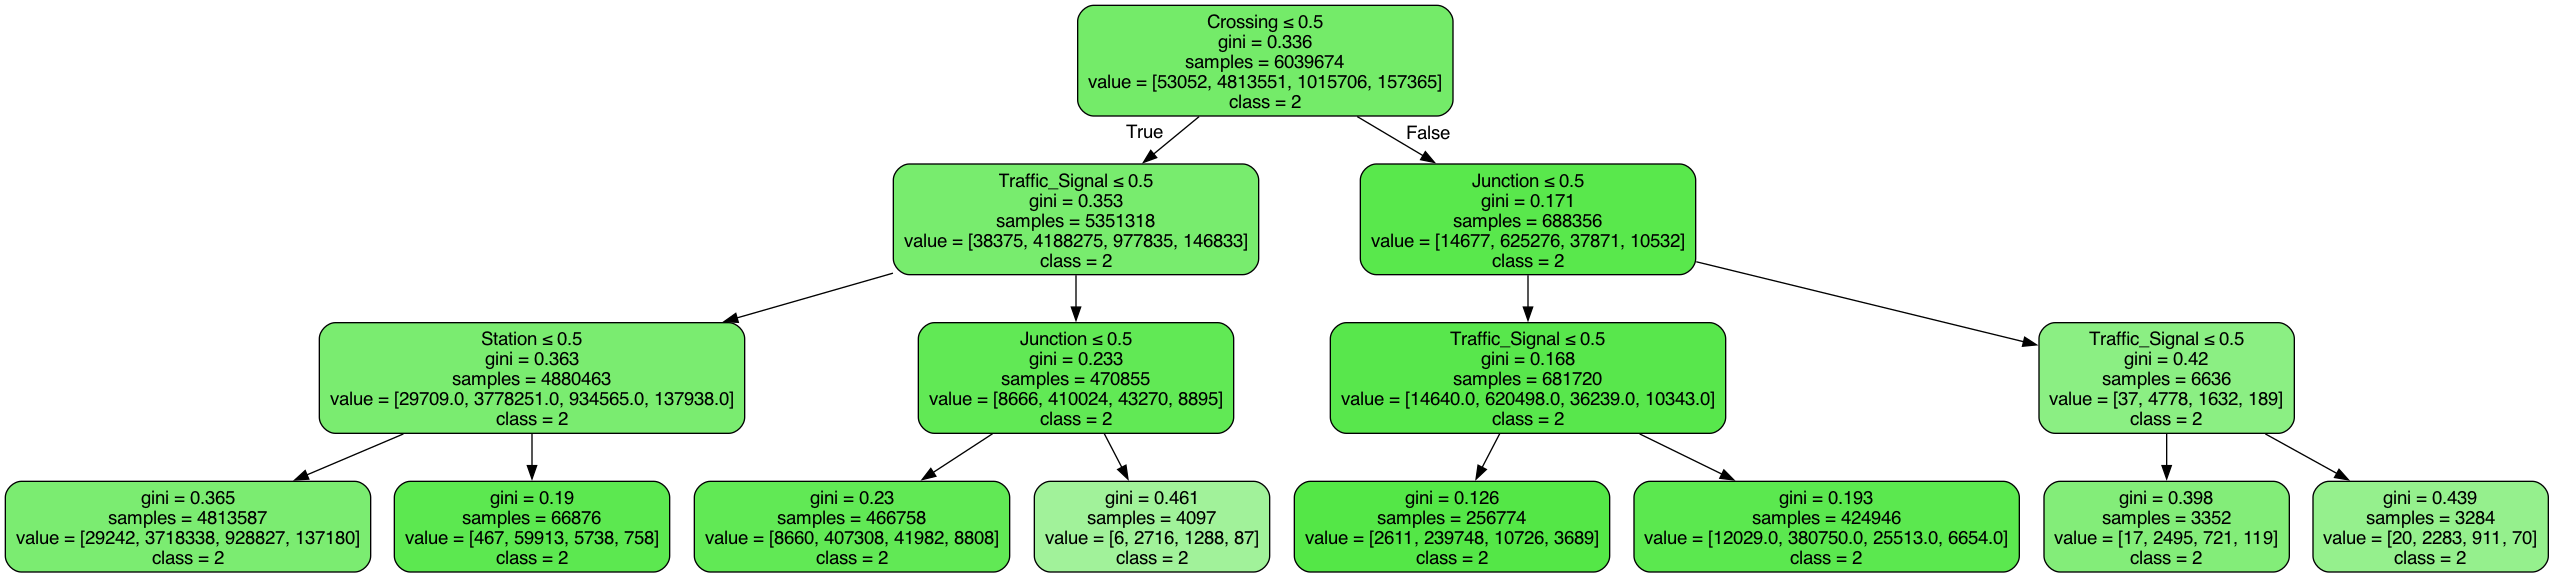

In [41]:
Image(filename="decision_tree_location_features.png")

<h5> Observations </h5>

1. No Crossing -> No Traffic_Signal -> If A Station -> Likely an Accident.
2. Crossing -> No Junction -> Likely an Accident.

<h3> Rules Based on Road Infrastructure Features </h3>

In [175]:
X = df_road_infra[road_infrastructure_features]
y = df_road_infra[target]

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [178]:
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [179]:
y_pred = dt_model.predict(X_test)

In [181]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [182]:
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.7971523296351634
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     13144
           2       0.80      1.00      0.89   1203633
           3       0.79      0.00      0.00    253957
           4       0.00      0.00      0.00     39202

    accuracy                           0.80   1509936
   macro avg       0.40      0.25      0.22   1509936
weighted avg       0.77      0.80      0.71   1509936



In [60]:
dot_data = export_graphviz(dt_model, out_file=None, 
                           feature_names= road_infrastructure_features,  
                           class_names=[str(i) for i in range(1, 6)],  
                           filled=True, rounded=True,  
                           special_characters=True)

graph = graphviz.Source(dot_data)

In [62]:
graph.render("decision_tree_road_features", format="png", cleanup=True)

'Q2/decision_tree_road_features.png'

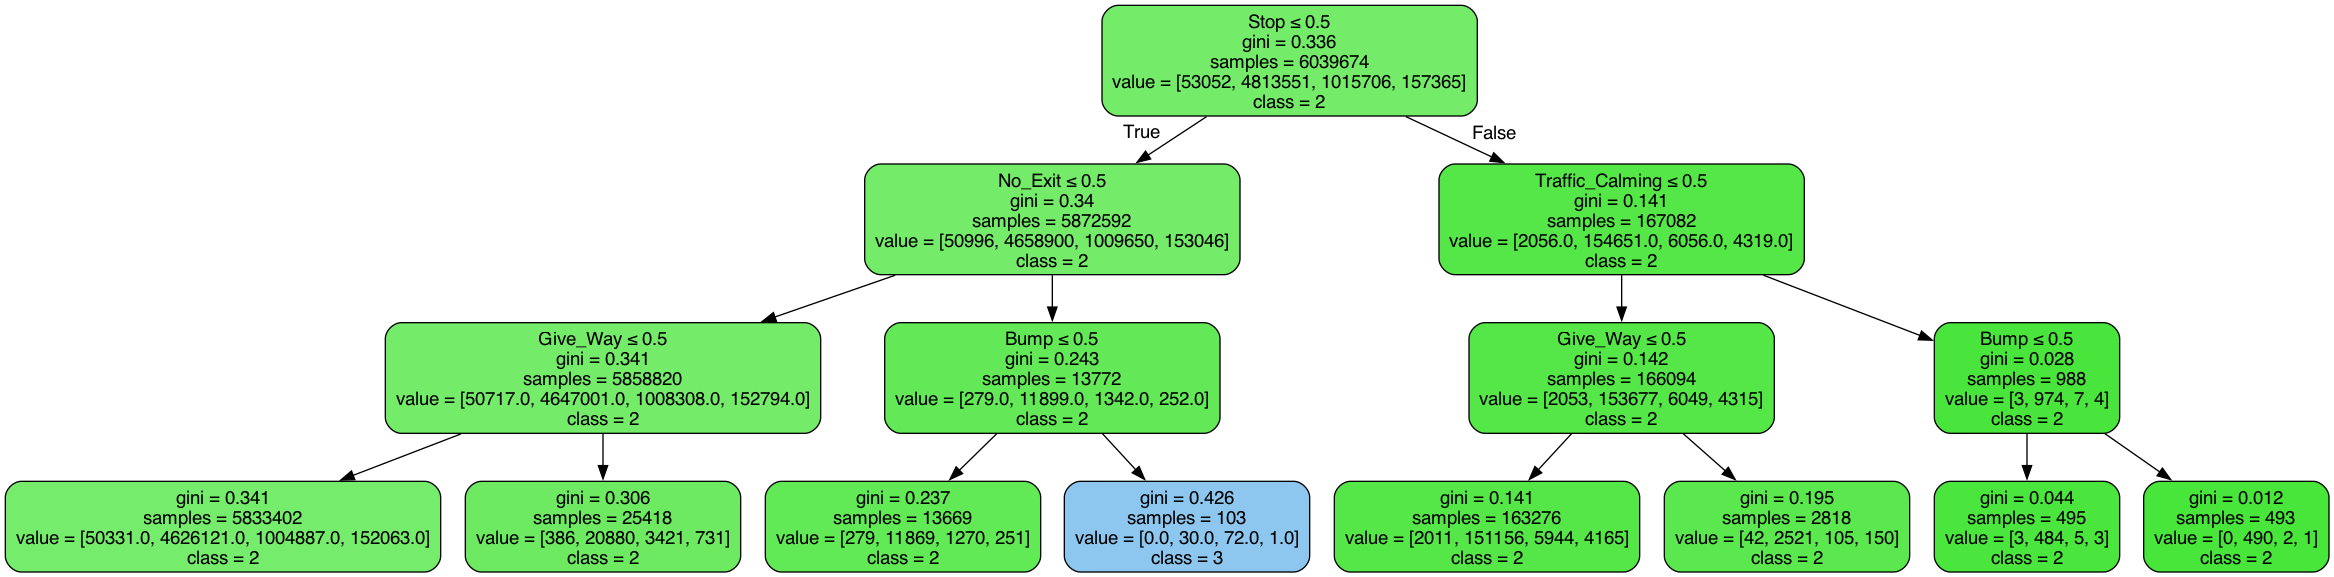

In [64]:
Image(filename="decision_tree_road_features.png")

<h2> Observations </h2>

1. No Stop Sign-> No_Exit Sign not Present -> Accident likely
2. No Stop Sign -> No_Exit Sign Present -> Bump Present -> Severe Accident Likely
3. Stop Sign Present -> No Traffic Calming -> Accident Likely


In [187]:
X = df[road_infrastructure_features + location_features]
y = df[target]

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [189]:
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [191]:
y_pred = dt_model.predict(X_test)

In [192]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [193]:
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.7971457068379058
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     13144
           2       0.80      1.00      0.89   1203633
           3       0.60      0.00      0.00    253957
           4       0.00      0.00      0.00     39202

    accuracy                           0.80   1509936
   macro avg       0.35      0.25      0.22   1509936
weighted avg       0.74      0.80      0.71   1509936



In [125]:
dot_data = export_graphviz(dt_model, out_file=None, 
                           feature_names= road_infrastructure_features + location_features,  
                           class_names=[str(i) for i in range(1, 6)],  
                           filled=True, rounded=True,  
                           special_characters=True)

graph = graphviz.Source(dot_data)

In [127]:
graph.render("decision_tree_road&location_features", format="png", cleanup=True)

'Q2/decision_tree_road&location_features.png'

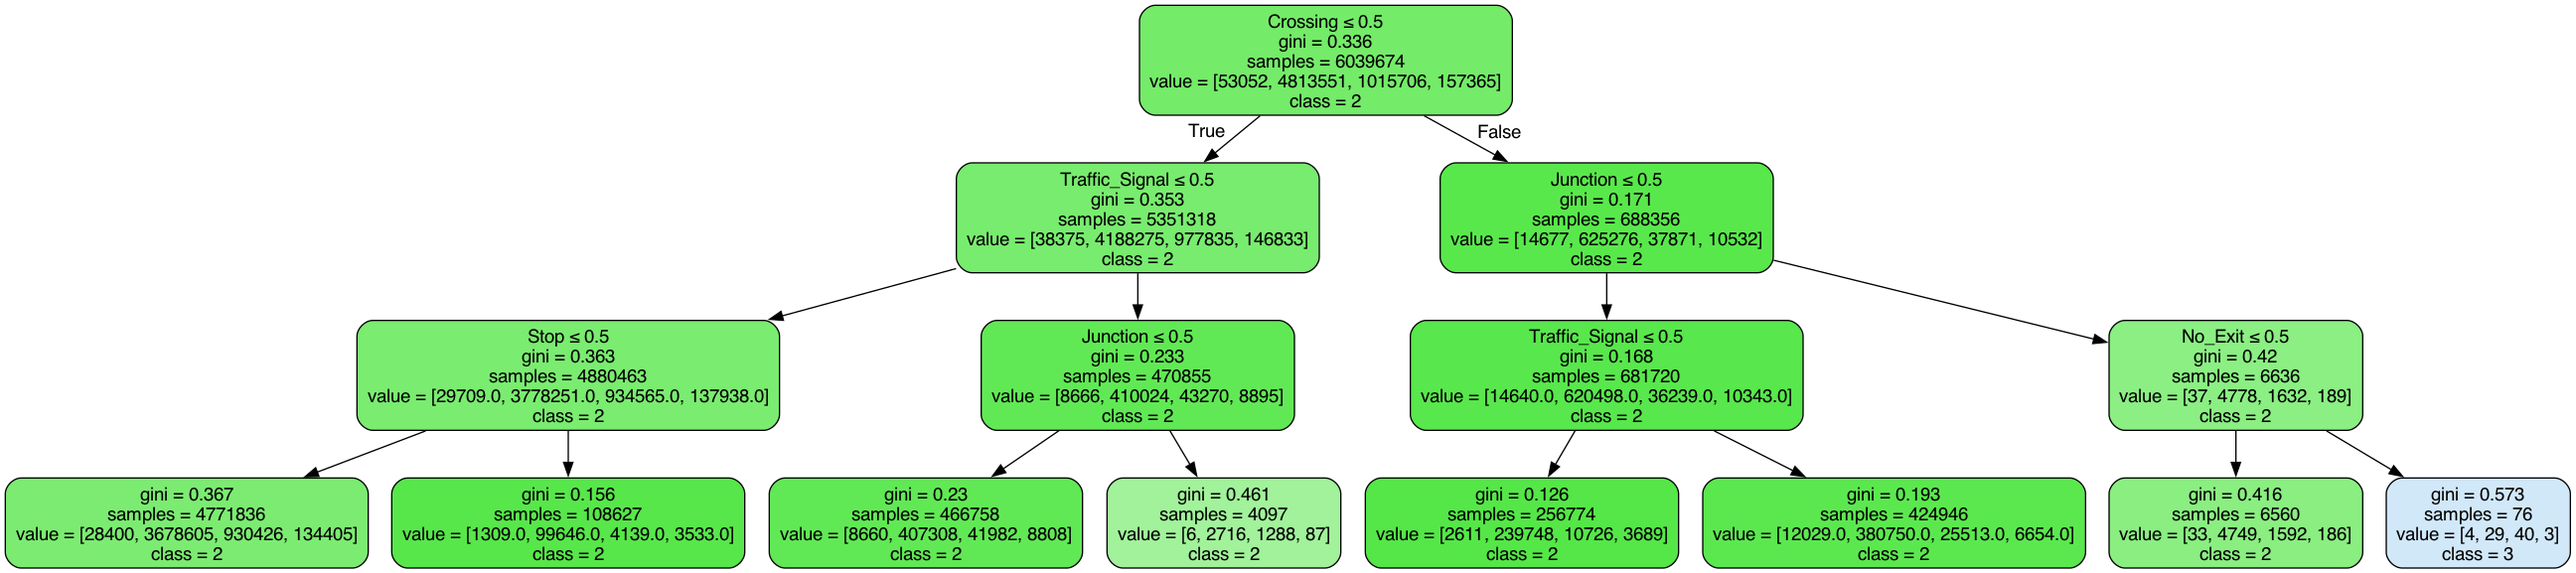

In [129]:
Image(filename="decision_tree_road&location_features.png")

<h2> Observations </h2>

1. No Crossing -> NO Traffic Signal -> Accident Likely
2. No Crossing -> Traffic Signal -> No Junction -> Accident Likely
3. Crossing -> No Junction -> Accident Likely

<h2> Assosciation Rule Mining </h2>

In [199]:
df_sample, df_test = train_test_split(df, test_size=0.95, random_state=42)

print(f"Training set size: {df_sample.shape}")
print(f"Testing set size: {df_test.shape}")

Training set size: (377483, 44)
Testing set size: (7172193, 44)


In [200]:
df.shape

(7549676, 44)

In [203]:
df_sample['Severity'] = df_sample['Severity'].astype('category')

In [205]:
df_mining = df_sample[road_infrastructure_features + location_features]

In [207]:
categorical = weather_categories + ["Severity"]

In [209]:
df_dummies = pd.get_dummies(df_sample[categorical], prefix = categorical)

In [211]:
df_mining = pd.concat([df_mining, df_dummies], axis=1)

In [213]:
df_mining.shape

(377483, 39)

In [215]:
df_mining.head()

Bump  Give_Way  No_Exit  Stop  Traffic_Calming  Crossing  Junction  \
5367125     0         0        0     0                0         0         0   
4364650     0         0        0     0                0         0         0   
3503893     0         0        0     0                0         0         0   
2079863     0         0        0     0                0         0         0   
6944834     0         0        0     0                0         0         0   

         Railway  Roundabout  Station  ...  \
5367125        0           0        0  ...   
4364650        0           0        0  ...   
3503893        0           0        0  ...   
2079863        0           0        0  ...   
6944834        0           0        0  ...   

         Visibility_Category_High Visibility  Temperature_Category_Very Cold  \
5367125                                 True                           False   
4364650                                 True                           False   
3503893                                 True                           False   
2079863                                 True                           False   
6944834                                 True                           False   

         Temperature_Category_Cold  Temperature_Category_Moderate  \
5367125                       True                          False   
4364650                       True                          False   
3503893                      False                          False   
2079863                      False                          False   
6944834                      False                           True   

         Temperature_Category_Hot  Temperature_Category_Very Hot  Severity_1  \
5367125                     False                          False       False   
4364650                     False                          False       False   
3503893                      True                          False       False   
2079863                      True                          False       False   
6944834                     False                          False       False   

         Severity_2  Severity_3  Severity_4  
5367125        True       False       False  
4364650        True       False       False  
3503893        True       False       False  
2079863        True       False       False  
6944834        True       False       False  

[5 rows x 39 columns]

In [100]:
frequent_itemsets = apriori(df_mining, min_support=0.05, use_colnames=True)

/opt/anaconda3/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [55]:
type(frequent_itemsets)

pandas.core.frame.DataFrame

In [102]:
rules = association_rules(df = frequent_itemsets, metric="confidence", min_threshold=0.6, num_itemsets = df_mining.shape[0] )

In [112]:
severity_rules = rules[rules['consequents'].apply(lambda x: 'Severity' in str(x))]
severity_rules.head()

antecedents   consequents  antecedent support  \
6                  (Crossing)  (Severity_2)            0.113230   
11                 (Junction)  (Severity_2)            0.073355   
16           (Traffic_Signal)  (Severity_2)            0.148527   
36  (Distance_Category_Short)  (Severity_2)            0.981440   
42    (Humidity_Category_Low)  (Severity_2)            0.168086   

    consequent support   support  confidence      lift  representativity  \
6             0.797154  0.102943    0.909153  1.140498               1.0   
11            0.797154  0.053481    0.729072  0.914593               1.0   
16            0.797154  0.130958    0.881711  1.106073               1.0   
36            0.797154  0.783490    0.798306  1.001445               1.0   
42            0.797154  0.136039    0.809343  1.015290               1.0   

    leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
6   0.012682    2.232818       0.138920  0.127494   0.552135    0.519146  
11 -0.004994    0.748707      -0.091549  0.065458  -0.335636    0.398081  
16  0.012559    1.714829       0.112629  0.160740   0.416852    0.522997  
36  0.001131    1.005713       0.077765  0.787344   0.005680    0.890583  
42  0.002049    1.063930       0.018103  0.164061   0.060088    0.490000

<h2> Observations </h2>

<b> If Crossing occurs, then Severity_2 occurs. </b>


Justification:
Confidence (90.92%) indicates a very high likelihood that if a Crossing is present, the accident will be of severity level Severity_2. The high confidence suggests a strong relationship between Crossing and Severity_2. <br> <br>
Lift (1.14) shows that the likelihood of Severity_2 occurring is 1.14 times higher when Crossing is involved, compared to the overall occurrence of Severity_2 in the dataset.
This means the presence of Crossing significantly increases the chances of the accident being classified as Severity_2.

<b> If Junction occurs, then Severity_2 occurs. </b>

Confidence (72.91%) indicates a moderate likelihood that if a Junction is involved, the accident will be Severity_2. However, it's lower compared to the previous rule. <br> <br>
Lift (0.91) is less than 1, which means that the occurrence of Junction slightly decreases the likelihood of Severity_2 occurring when compared to the general distribution of Severity_2. This suggests that accidents at junctions may be less likely to be of high severity (Severity_2).

<b> If Traffic Signal occurs, then Severity_2 occurs. </b>

Confidence (88.17%) suggests that if a Traffic Signal is involved in an accident, there is a high chance that the severity will be Severity_2. This indicates a strong link between the presence of a traffic signal and accidents being classified as Severity_2. <br> <br>
Lift (1.11) means that the likelihood of Severity_2 occurring is 1.11 times higher when Traffic Signal is present in the accident, indicating a positive association between traffic signals and higher severity accidents.

<b>  If Distance_Category_Short occurs, then Severity_2 occurs. </b>

Confidence (79.83%) indicates that there is a moderate-to-high chance that if an accident involves a Distance_Category_Short (short distance), it will be classified as Severity_2. <br> <br>
Lift (1.00) indicates that the occurrence of Severity_2 is neither enhanced nor diminished when the distance is short. It shows that accidents of short distance have a neutral impact on the likelihood of high severity (Severity_2) accidents.

<b> If Humidity_Category_Low occurs, then Severity_2 occurs. </b>

Confidence (80.93%) shows that the presence of Humidity_Category_Low has a relatively strong association with accidents being classified as Severity_2. <br> <br>
Lift (1.02) indicates that accidents with low humidity are slightly more likely to be Severity_2 compared to the general occurrence of Severity_2, suggesting that lower humidity could play a minor role in the severity of accidents.

<h2> Q.3 Are Californians worse drivers than average? Which state has the best and worst drivers?
</h2>

In [232]:
drivers = pd.read_pickle('reg_driver_data.pkl')

In [234]:
drivers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 0 to 50
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   44 non-null     object 
 1   2006    44 non-null     float64
 2   2007    44 non-null     float64
 3   2008    44 non-null     float64
 4   2009    44 non-null     float64
 5   2010    44 non-null     float64
 6   2011    44 non-null     float64
 7   2012    44 non-null     float64
 8   2013    44 non-null     float64
 9   2014    44 non-null     float64
 10  2015    44 non-null     float64
 11  2016    44 non-null     float64
 12  2017    44 non-null     float64
 13  2018    44 non-null     float64
 14  2019    44 non-null     float64
 15  2020    44 non-null     float64
 16  2021    44 non-null     float64
 17  2022    44 non-null     float64
dtypes: float64(17), object(1)
memory usage: 6.5+ KB


In [236]:
group = df.groupby(['State','Year'], as_index = False)

In [238]:
drivers = drivers.melt(
    id_vars='State', 
    var_name='Year', 
    value_name='Driver_Population'
)

In [240]:
drivers['State'] = drivers['State'].str.lower()

In [242]:
drivers

State  Year  Driver_Population
0      al  2006          3665180.0
1      az  2006          4032643.0
2      ar  2006          2034975.0
3      ca  2006         23021279.0
4      ct  2006          2805124.0
..    ...   ...                ...
743    va  2022          5837147.0
744    wa  2022          5956048.0
745    wv  2022          1148406.0
746    wi  2022          4374582.0
747    wy  2022           431900.0

[748 rows x 3 columns]

In [244]:
drivers['Year'] = pd.to_datetime(drivers['Year'], format='%Y')

In [246]:
state_year_count = group.size()

In [262]:
state_year_count['Year'] = state_year_count['Year'].dt.year

In [274]:
state_year_count['Year'] = pd.to_datetime(state_year_count['Year'], format='%Y')


In [284]:
state_year_count["State"] = state_year_count["State"].str.lower()

In [286]:
merged_data = pd.merge(state_year_count, drivers, on=['State', 'Year'], how='inner')

In [288]:
merged_data

State       Year   size  Driver_Population
0      al 2016-01-01    132          3943082.0
1      al 2017-01-01   2858          3954378.0
2      al 2018-01-01  13937          3999057.0
3      al 2019-01-01  19090          4026151.0
4      al 2020-01-01  19870          4042900.0
..    ...        ...    ...                ...
303    wy 2018-01-01    190           419256.0
304    wy 2019-01-01    109           424115.0
305    wy 2020-01-01     27           427233.0
306    wy 2021-01-01    724           430472.0
307    wy 2022-01-01   1819           431900.0

[308 rows x 4 columns]

In [290]:
merged_data['Accidents/Driver'] = merged_data['size'] / merged_data['Driver_Population']

In [292]:
merged_data.nlargest(columns= 'Accidents/Driver', n = 10)

State       Year    size  Driver_Population  Accidents/Driver
237    sc 2022-01-01   83436          4091650.0          0.020392
236    sc 2021-01-01   78127          3990909.0          0.019576
272    va 2022-01-01   94289          5837147.0          0.016153
235    sc 2020-01-01   61754          3905911.0          0.015810
48     fl 2022-01-01  260063         16495556.0          0.015766
153    mt 2022-01-01   13455           870882.0          0.015450
234    sc 2019-01-01   58119          3877968.0          0.014987
47     fl 2021-01-01  238421         16144302.0          0.014768
233    sc 2018-01-01   54780          3846069.0          0.014243
27     ca 2022-01-01  367072         27632103.0          0.013284

In [294]:
statewise_data = merged_data.groupby('State', as_index=False).agg({
    'Accidents/Driver': 'mean'
})

statewise_data = statewise_data.sort_values(by='Accidents/Driver', ascending=False)

In [296]:
statewise_data['Accidents/Driver'] = statewise_data['Accidents/Driver'] * 100

In [298]:
statewise_data.nsmallest(columns = 'Accidents/Driver', n = 4)

State  Accidents/Driver
34    sd          0.006071
39    vt          0.024082
16    me          0.036089
23    nd          0.075961

In [300]:
national_avg = statewise_data['Accidents/Driver'].mean()

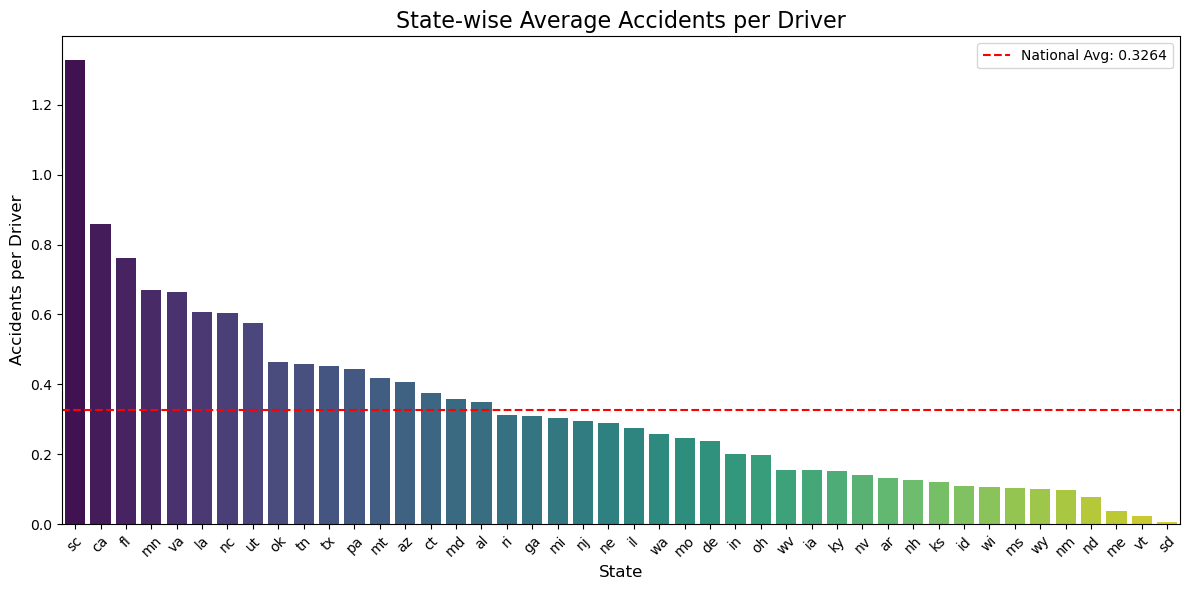

In [302]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='State', 
    y='Accidents/Driver', 
    data=statewise_data, 
    palette='viridis'
)


plt.axhline(y=statewise_data['Accidents/Driver'].mean(), color='r', linestyle='--', label=f'National Avg: {national_avg:.4f}')


plt.title('State-wise Average Accidents per Driver', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Accidents per Driver', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend()


# plt.gcf().savefig("Accidents_Driver.png")
plt.show()


In [304]:
state_severity_counts = df.groupby(['State', 'Severity']).size().reset_index(name='Counts')

In [305]:
top_states = (
    state_severity_counts.groupby('State')['Counts']
    .sum()
    .nlargest(10)
    .index
)


filtered_data = state_severity_counts[state_severity_counts['State'].isin(top_states)]

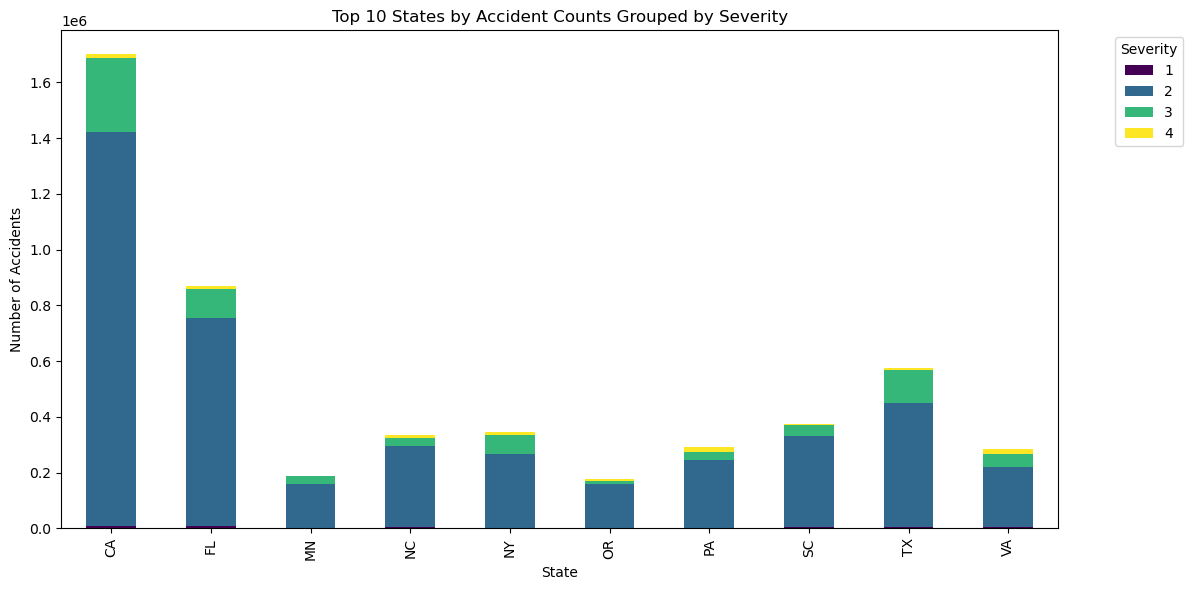

In [308]:
pivot_data = filtered_data.pivot(index='State', columns='Severity', values='Counts').fillna(0)

pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap="viridis")

plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.title('Top 10 States by Accident Counts Grouped by Severity')
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# plt.gcf().savefig('Top_10_Accidents_Severity_Statewise.png')
plt.show()

In [310]:
state_city_counts = df.groupby(['State', 'City']).size().reset_index(name='Accident_Count')

top5_cities = state_city_counts.groupby('State').apply(lambda x: x.nlargest(5, 'Accident_Count')).reset_index(drop=True)

/var/folders/31/89q4lfy92jx4lp6kwytq6lmw0000gn/T/ipykernel_83944/4197713194.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5_cities = state_city_counts.groupby('State').apply(lambda x: x.nlargest(5, 'Accident_Count')).reset_index(drop=True)


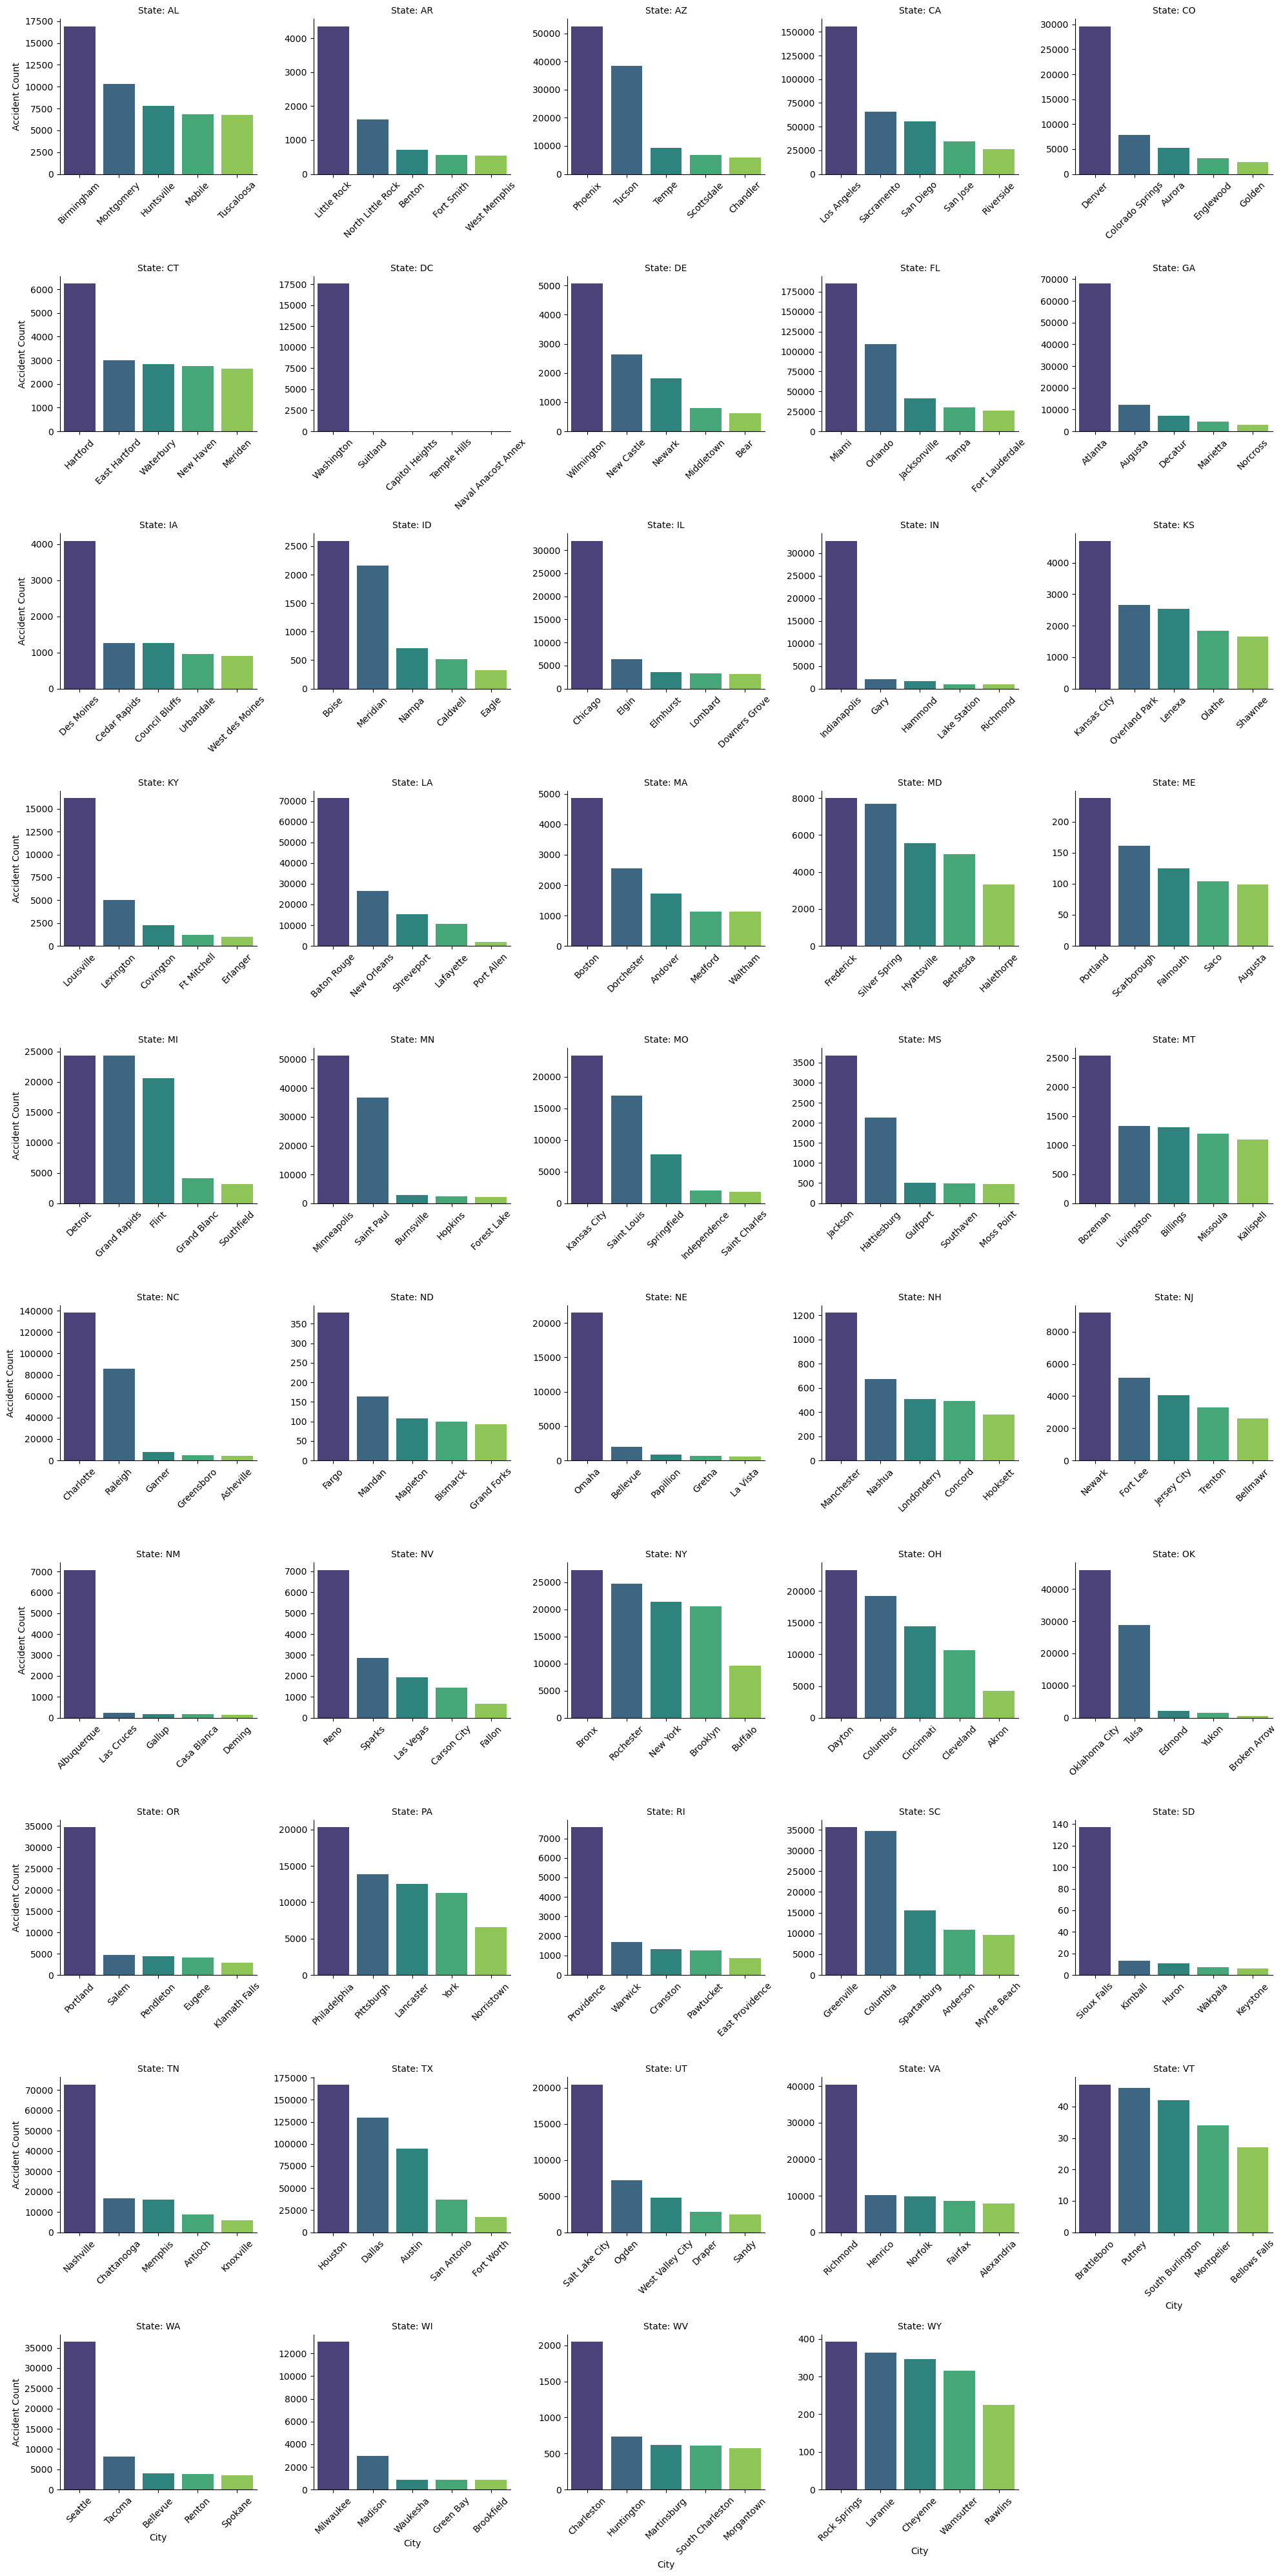

In [311]:
top5_cities['State'] = top5_cities['State'].astype(str)
top5_cities['City'] = top5_cities['City'].astype(str)


top5_cities = top5_cities.sort_values(['State', 'Accident_Count'], ascending=[True, False])


g = sns.FacetGrid(top5_cities, col='State', col_wrap=5, height=4, sharex=False, sharey=False)

g.map_dataframe(sns.barplot, x='City', y='Accident_Count', palette='viridis', order=None)


g.set_titles("State: {col_name}")
g.set_axis_labels("City", "Accident Count")


for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


plt.tight_layout()
# plt.gcf().savefig("state_hotspots.png")
plt.show()

In [314]:
severity_by_state = df.groupby('State')['Severity'].value_counts().unstack().fillna(0)

print("State-wise Severity Distribution:")
print(severity_by_state.head(10))

State-wise Severity Distribution:
Severity        1          2         3        4
State                                          
AL          666.0    75932.0   21313.0   1779.0
AR           37.0    18846.0     644.0   2748.0
AZ         7329.0   135641.0   16688.0   4875.0
CA        10083.0  1411823.0  266827.0  12645.0
CO          968.0    55250.0   26017.0   7158.0
CT           72.0    50242.0   16298.0   4139.0
DC          137.0    15714.0    1023.0    749.0
DE          233.0    11525.0     712.0   1538.0
FL         7000.0   747514.0  102803.0  12908.0
GA          993.0    92512.0   60527.0  12416.0


In [316]:
severity_1_2_count = df[df['Severity'].isin([1, 2])].groupby('State').size()
severity_3_4_count = df[df['Severity'].isin([3, 4])].groupby('State').size()

severity_counts = pd.DataFrame({
    'Severity_1_2': severity_1_2_count,
    'Severity_3_4': severity_3_4_count
})


severity_counts['Severity_Ratio'] = severity_counts['Severity_3_4'] / severity_counts['Severity_1_2']

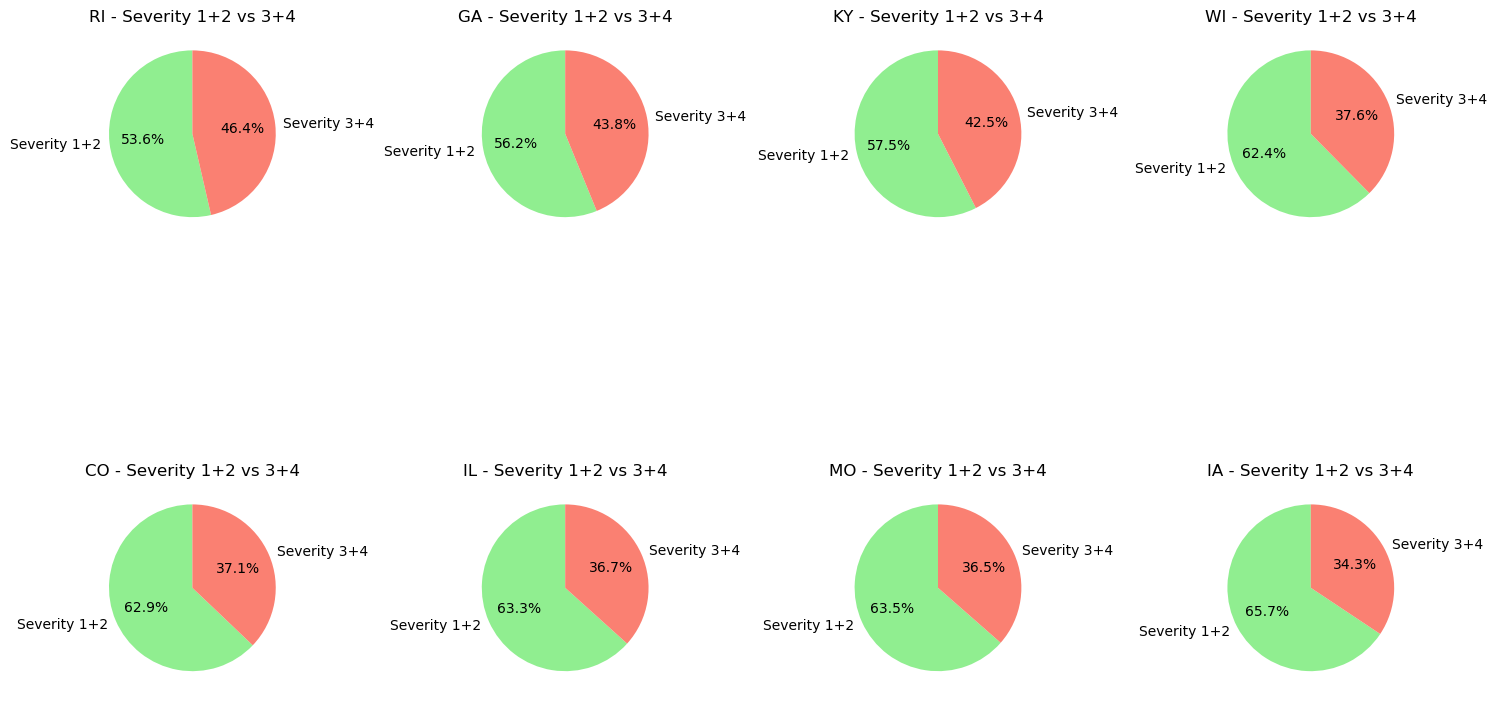

In [317]:
top_8_states = severity_counts.sort_values(by='Severity_Ratio', ascending=False).head(8)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
axes = axes.flatten()

for i, state in enumerate(top_8_states.index):
    sizes = [top_8_states.loc[state, 'Severity_1_2'], top_8_states.loc[state, 'Severity_3_4']]
    labels = ['Severity 1+2', 'Severity 3+4']
    axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'salmon'], startangle=90)
    axes[i].set_title(f"{state} - Severity 1+2 vs 3+4")


plt.tight_layout()
# plt.gcf().savefig("states_with_Severe_accidents.png")
plt.show()





<h2> Observation </h2>

1. Ratio of Severe Accidens is significantly high in states on the easy coast